In [649]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('fivethirtyeight')

from statsmodels.tsa.stattools import adfuller

from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.cross_validation import train_test_split
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
from pyramid.arima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.vector_ar.hypothesis_test_results import \
    CausalityTestResults, NormalityTestResults, WhitenessTestResults

In [650]:
# import tensorflow as tf # This code has been tested with TensorFlow 1.6
# from sklearn.preprocessing import MinMaxScaler

In [872]:
import statsmodels.api as sm

In [866]:
from statsmodels.tsa.stattools import add_constant

In [875]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

### Importing Data

In [651]:
btc_df=pd.read_csv("data/btc_df.csv", parse_dates=['Date'],index_col='Date')

In [652]:
gold_df=pd.read_csv('data/gold_df.csv',parse_dates=['Date'],index_col='Date')

In [653]:
currency_I_df=pd.read_csv('data/currecy_I_df.csv',parse_dates=['Date'],index_col='Date')

In [654]:
currency_II_df=pd.read_csv('data/currecy_II_df.csv',parse_dates=['Date'],index_col='Date')

In [655]:
vix_df=pd.read_csv('data/cobe_vix_df.csv',parse_dates=['Date'],index_col='Date')

In [656]:
sp500_df=pd.read_csv('data/SP500_df.csv',parse_dates=['Date'],index_col='Date')

### Data Preprocessing for Merging 

In [657]:
# btc_df.info()
# btc_df.head()
# btc_df.describe()
print(btc_df.isnull().sum()) # Features with high missing values will be dropped

BCHAIN/TOTBC      1
BCHAIN/MKTCP      6
BCHAIN/TRFEE      0
BCHAIN/TRFUS      6
BCHAIN/NETDF    710
BCHAIN/NTRAN      0
BCHAIN/NTRAT      0
BCHAIN/NTREP      0
BCHAIN/NADDU      0
BCHAIN/NTRBL      0
BCHAIN/TOUTV      0
BCHAIN/ETRAV      0
BCHAIN/ETRVU      6
BCHAIN/TRVOU      6
BCHAIN/TVTVR    710
BCHAIN/MKPRU      0
BCHAIN/CPTRV      0
BCHAIN/CPTRA      6
BCHAIN/HRATE      1
BCHAIN/MIREV      6
BCHAIN/ATRCT      0
BCHAIN/BCDDC    707
BCHAIN/BCDDE    707
BCHAIN/BCDDW    707
BCHAIN/BCDDM    707
BCHAIN/BCDDY    707
BCHAIN/BLCHS      0
BCHAIN/AVBLS      0
BCHAIN/MWTRV      0
BCHAIN/MWNUS     24
BCHAIN/MWNTD      0
BCHAIN/MIOPM    741
BCHAIN/DIFF       0
dtype: int64


In [658]:
# following the observed missing values , I will drop variables with  higher number of NAs. 
columns_drop=['BCHAIN/NETDF',"BCHAIN/TVTVR","BCHAIN/BCDDC", "BCHAIN/BCDDE","BCHAIN/BCDDW", "BCHAIN/BCDDM","BCHAIN/BCDDY","BCHAIN/MIOPM"]
btc_df.drop(columns_drop, axis=1, inplace=True)
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3463 entries, 2009-01-03 to 2018-06-27
Data columns (total 25 columns):
BCHAIN/TOTBC    3462 non-null float64
BCHAIN/MKTCP    3457 non-null float64
BCHAIN/TRFEE    3463 non-null float64
BCHAIN/TRFUS    3457 non-null float64
BCHAIN/NTRAN    3463 non-null float64
BCHAIN/NTRAT    3463 non-null float64
BCHAIN/NTREP    3463 non-null float64
BCHAIN/NADDU    3463 non-null float64
BCHAIN/NTRBL    3463 non-null float64
BCHAIN/TOUTV    3463 non-null float64
BCHAIN/ETRAV    3463 non-null float64
BCHAIN/ETRVU    3457 non-null float64
BCHAIN/TRVOU    3457 non-null float64
BCHAIN/MKPRU    3463 non-null float64
BCHAIN/CPTRV    3463 non-null float64
BCHAIN/CPTRA    3457 non-null float64
BCHAIN/HRATE    3462 non-null float64
BCHAIN/MIREV    3457 non-null float64
BCHAIN/ATRCT    3463 non-null float64
BCHAIN/BLCHS    3463 non-null float64
BCHAIN/AVBLS    3463 non-null float64
BCHAIN/MWTRV    3463 non-null float64
BCHAIN/MWNUS    3439 non-null float64
B

In [659]:
btc_df=btc_df.asfreq("D")# Our data is  has included all the calander days.
btc_df.isnull().sum()
# Now, filling the missing values is the next step. I prefere to propagate a forward fill
btc_df.fillna(method='ffill', inplace=True)

SP&500

In [660]:
sp500_df.info()
#sp500_df.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2387 entries, 2009-01-02 to 2018-06-26
Data columns (total 6 columns):
Open         2387 non-null float64
High         2387 non-null float64
Low          2387 non-null float64
Close        2387 non-null float64
Adj Close    2387 non-null float64
Volume       2387 non-null int64
dtypes: float64(5), int64(1)
memory usage: 130.5 KB


In [661]:
# I prefer to use the closing price, since i am using the ffill, it is a better approximation 
sp500_close_df=sp500_df.drop(['Open',"High","Low","Adj Close", "Volume"], axis=1)
sp500_close_df.isnull().sum()

Close    0
dtype: int64

In [662]:
# resampling/changing frequency and filling na
sp500_close_df=sp500_close_df.asfreq('D', method = 'ffill')
sp500_close_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3463 entries, 2009-01-02 to 2018-06-26
Freq: D
Data columns (total 1 columns):
Close    3463 non-null float64
dtypes: float64(1)
memory usage: 54.1 KB


Closing Price of Gold

In [663]:
gold_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12759 entries, 1968-01-02 to 2018-06-26
Data columns (total 1 columns):
gold_price    12758 non-null float64
dtypes: float64(1)
memory usage: 199.4 KB


In [664]:
gold_price_df=gold_df['2009-01-02':]
gold_price_df.isnull().sum()
gold_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2395 entries, 2009-01-02 to 2018-06-26
Data columns (total 1 columns):
gold_price    2395 non-null float64
dtypes: float64(1)
memory usage: 37.4 KB


In [665]:
gold_price_df=gold_price_df.asfreq("D", method='ffill')
gold_price_df.isnull().sum()
gold_price_df.drop(gold_price_df.index[0], inplace=True)
gold_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3462 entries, 2009-01-03 to 2018-06-26
Freq: D
Data columns (total 1 columns):
gold_price    3462 non-null float64
dtypes: float64(1)
memory usage: 54.1 KB


In [666]:
gold_price_df.head()

,gold_price
Date,
2009-01-03,869.75
2009-01-04,869.75
2009-01-05,860.00
2009-01-06,844.00
2009-01-07,864.00


Volatility Index

In [667]:
vix_df.info()
vix_close_df=vix_df.drop(['Open',"High","Low","Adj Close", "Volume"], axis=1)
vix_close_df.isnull().sum()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2387 entries, 2009-01-02 to 2018-06-26
Data columns (total 6 columns):
Open         2387 non-null float64
High         2387 non-null float64
Low          2387 non-null float64
Close        2387 non-null float64
Adj Close    2387 non-null float64
Volume       2387 non-null int64
dtypes: float64(5), int64(1)
memory usage: 130.5 KB


Close    0
dtype: int64

In [668]:
vix_close_df=vix_close_df.asfreq('D', method='ffill')
vix_close_df.drop(vix_close_df.index[0], inplace= True)
vix_close_df.rename({'Close':'vix_closing_price'},axis=1, inplace=True)
vix_close_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3462 entries, 2009-01-03 to 2018-06-26
Freq: D
Data columns (total 1 columns):
vix_closing_price    3462 non-null float64
dtypes: float64(1)
memory usage: 54.1 KB


In [669]:
vix_close_df.head()

,vix_closing_price
Date,
2009-01-03,39.189999
2009-01-04,39.189999
2009-01-05,39.080002
2009-01-06,38.560001
2009-01-07,43.389999


Currency (EUR/USD, USD/JPY)

In [670]:
currency_I_df.columns

Index(['EUR/USD Close', 'EUR/USD High', 'EUR/USD Low', 'USD/JPY Close',
       'USD/JPY High', 'USD/JPY Low'],
      dtype='object')

In [671]:
currency_I_df.drop(['EUR/USD High', 'EUR/USD Low', 
       'USD/JPY High', 'USD/JPY Low'],axis=1, inplace=True)

In [672]:
currency_I_close_df=currency_I_df.asfreq('D', method='ffill')
currency_I_close_df.drop(currency_I_close_df.index[0:2],inplace=True)
currency_I_close_df.head()

,EUR/USD Close,USD/JPY Close
Date,,
2009-01-03,1.3855,92.21
2009-01-04,1.3855,92.21
2009-01-05,1.3600,93.20
2009-01-06,1.3527,93.96
2009-01-07,1.3628,92.68


Currencey( CNY/USD)

In [673]:
currency_II_df.head(5)

,Open,High,Low,Close
Date,,,,
2009-01-01,6.8280,6.8280,6.8280,6.8280
2009-01-02,6.8245,6.8245,6.8245,6.8245
2009-01-05,6.8372,6.8372,6.8372,6.8372
2009-01-06,6.8375,6.8375,6.8375,6.8375
2009-01-07,6.8364,6.8364,6.8364,6.8364


In [674]:
currency_II_df.columns

Index([' Open', ' High', ' Low', ' Close'], dtype='object')

In [675]:
currency_II_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2474 entries, 2009-01-01 to 2018-06-26
Data columns (total 4 columns):
 Open     2474 non-null float64
 High     2474 non-null float64
 Low      2474 non-null float64
 Close    2474 non-null float64
dtypes: float64(4)
memory usage: 96.6 KB


In [676]:
currency_II_df=currency_II_df.asfreq('D', method='ffill')

In [677]:
currency_II_close_df=currency_II_df.drop([' Open', ' High', ' Low'], axis=1)

In [678]:
currency_II_close_df.drop(currency_II_close_df.index[0:2], inplace=True)

In [679]:
currency_II_close_df.rename({' Close':'USD/CNY Close'},axis=1, inplace=True)

In [680]:
currency_II_close_df.head()

,USD/CNY Close
Date,
2009-01-03,6.8245
2009-01-04,6.8245
2009-01-05,6.8372
2009-01-06,6.8375
2009-01-07,6.8364


In [681]:
currency_II_close_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3462 entries, 2009-01-03 to 2018-06-26
Freq: D
Data columns (total 1 columns):
USD/CNY Close    3462 non-null float64
dtypes: float64(1)
memory usage: 54.1 KB


In [682]:
currency_II_df.isnull().sum()

 Open     0
 High     0
 Low      0
 Close    0
dtype: int64

## Merging All together

In [683]:
df=[currency_II_close_df, currency_I_close_df, btc_df, gold_price_df, sp500_close_df, vix_close_df]

In [684]:
final_df = pd.concat(df, axis=1)
final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3464 entries, 2009-01-02 to 2018-06-27
Freq: D
Data columns (total 31 columns):
USD/CNY Close        3462 non-null float64
EUR/USD Close        3462 non-null float64
USD/JPY Close        3462 non-null float64
BCHAIN/TOTBC         3463 non-null float64
BCHAIN/MKTCP         3463 non-null float64
BCHAIN/TRFEE         3463 non-null float64
BCHAIN/TRFUS         3463 non-null float64
BCHAIN/NTRAN         3463 non-null float64
BCHAIN/NTRAT         3463 non-null float64
BCHAIN/NTREP         3463 non-null float64
BCHAIN/NADDU         3463 non-null float64
BCHAIN/NTRBL         3463 non-null float64
BCHAIN/TOUTV         3463 non-null float64
BCHAIN/ETRAV         3463 non-null float64
BCHAIN/ETRVU         3463 non-null float64
BCHAIN/TRVOU         3463 non-null float64
BCHAIN/MKPRU         3463 non-null float64
BCHAIN/CPTRV         3463 non-null float64
BCHAIN/CPTRA         3463 non-null float64
BCHAIN/HRATE         3462 non-null float64
BCHAIN/

In [685]:
# Droping Missing Values 
final_df.dropna(inplace=True)

In [686]:
final_df.describe()

,USD/CNY Close,EUR/USD Close,USD/JPY Close,BCHAIN/TOTBC,BCHAIN/MKTCP,BCHAIN/TRFEE,BCHAIN/TRFUS,BCHAIN/NTRAN,BCHAIN/NTRAT,BCHAIN/NTREP,...,BCHAIN/ATRCT,BCHAIN/BLCHS,BCHAIN/AVBLS,BCHAIN/MWTRV,BCHAIN/MWNUS,BCHAIN/MWNTD,BCHAIN/DIFF,gold_price,Close,vix_closing_price
count,3461.000000,3461.000000,3461.000000,3.461000e+03,3.461000e+03,3461.000000,3.461000e+03,3461.000000,3.461000e+03,3461.000000,...,3461.000000,3461.000000,3461.000000,3.461000e+03,3.461000e+03,3461.000000,3.461000e+03,3461.000000,3461.000000,3461.000000
mean,6.478986,1.264053,99.005089,1.045541e+07,1.726988e+10,52.658522,2.434459e+05,93787.699220,7.050811e+07,86925.164403,...,6.725301,36136.870251,0.324577,9.594308e+04,4.294568e+06,25036.730714,2.937172e+11,1309.613219,1711.789778,18.487073
std,0.264516,0.118786,14.067077,5.310150e+06,4.451576e+10,109.782651,1.267187e+06,102887.265942,9.366149e+07,102085.404283,...,5.220901,49408.406602,0.359394,2.524165e+05,6.684005e+06,29252.078997,8.141247e+11,214.191150,527.443948,7.691563
min,6.041000,1.038720,75.720000,5.000000e+01,0.000000e+00,0.000000,0.000000e+00,0.000000,1.000000e+00,0.000000,...,0.000000,0.000000,0.000000,0.000000e+00,2.000000e+00,0.000000,0.000000e+00,813.000000,676.530029,9.140000
25%,6.232900,1.140090,85.760000,6.256250e+06,2.136330e+07,3.428995,9.189767e+00,4796.000000,5.266640e+05,3779.000000,...,0.000000,44.000000,0.009662,0.000000e+00,2.000000e+00,0.000000,2.441125e+05,1189.100000,1259.780029,13.280000
50%,6.429100,1.292000,100.119000,1.177365e+07,1.525042e+09,16.509725,3.781426e+03,56685.000000,2.465934e+07,36560.000000,...,7.633333,10195.000000,0.159857,3.197619e+04,4.523020e+05,9595.000000,1.488192e+08,1279.000000,1701.839966,16.200001
75%,6.773200,1.358500,110.860000,1.519852e+07,8.112594e+09,44.519552,1.814480e+04,181832.000000,1.094779e+08,176307.000000,...,9.833333,58188.000000,0.657941,1.364805e+05,6.018211e+06,47878.000000,1.441164e+11,1386.000000,2093.320068,21.309999
max,6.960700,1.513600,125.637000,1.711562e+07,3.265254e+11,1495.946477,2.272484e+07,490644.000000,3.244345e+08,470650.000000,...,47.733333,172522.335593,1.110327,8.484600e+06,2.556751e+07,122796.000000,5.077499e+12,1896.500000,2872.870117,56.650002


## ARIMA Model Building 

In [687]:
btc_price=final_df['BCHAIN/MKPRU']

In [688]:
btc_price.describe()

count     3461.000000
mean      1056.638364
std       2638.915393
min          0.000000
25%          2.930000
50%        135.601000
75%        596.080000
max      19498.683333
Name: BCHAIN/MKPRU, dtype: float64

In [689]:
#Remove rows of zero prices from a Pandas series
btc_price=btc_price[btc_price!=0]

In [690]:
len(btc_price[btc_price!=0])

2871

In [691]:
btc_price_df=pd.DataFrame(btc_price)

In [692]:
btc_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2871 entries, 2010-08-17 to 2018-06-26
Freq: D
Data columns (total 1 columns):
BCHAIN/MKPRU    2871 non-null float64
dtypes: float64(1)
memory usage: 44.9 KB


In [693]:
btc_price_df.head()

,BCHAIN/MKPRU
Date,
2010-08-17,0.076900
2010-08-18,0.074000
2010-08-19,0.068800
2010-08-20,0.066700
2010-08-21,0.066899


In [694]:
btc_price_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
BCHAIN/MKPRU,2871.0,1273.781044,2849.347949,0.0609,11.836,277.43,659.775,19498.683333


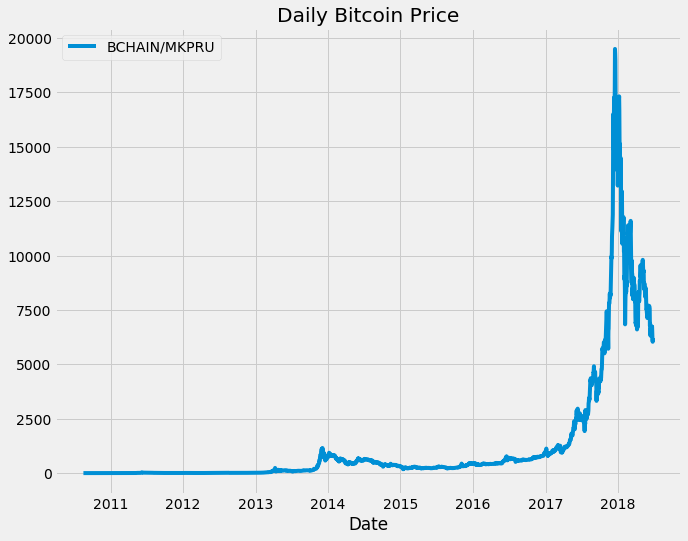

In [695]:
# A plotting the price movement 
fig, ax=plt.subplots(figsize=(10,8))
btc_price_df.plot(ax=ax, title="Daily Bitcoin Price")

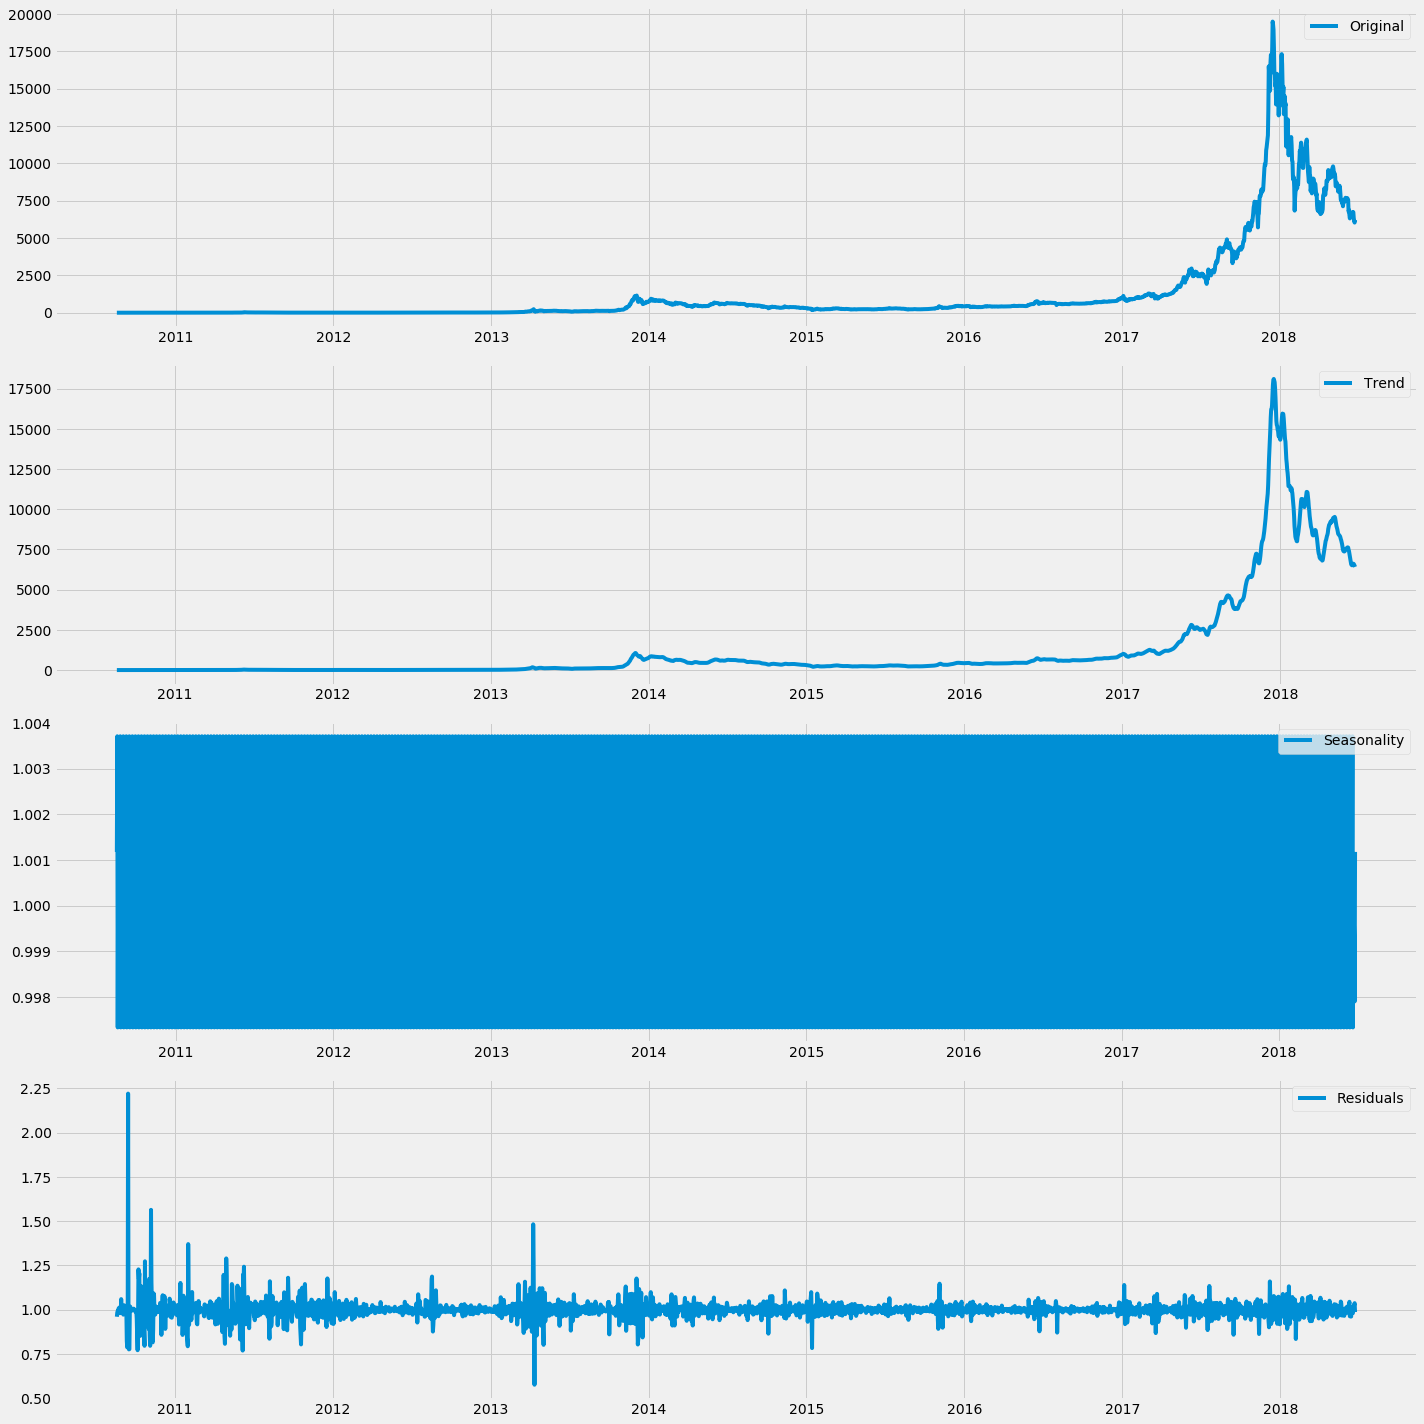

In [696]:
# Visualization of ETS decomposition 
decomposition = seasonal_decompose(btc_price_df["BCHAIN/MKPRU"], model="multiplicative")
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig, ax=plt.subplots(figsize=(20,20))
plt.subplot(411)
plt.plot(btc_price_df["BCHAIN/MKPRU"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

# Testing for stationarity

In [698]:
#Let's write a function to call for a plot and Adf test

In [699]:
def adf_test(df):
    #plot the series for visual inspection
    fig, ax=plt.subplots(figsize=(15,10))
    plt.plot(df,color='green')
    plt.title('Daily Price of Bitcoin')
    plt.show(block=False)
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    if dfoutput[1] <= 0.05:
        print("strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary")

    else:
        print("weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary ")

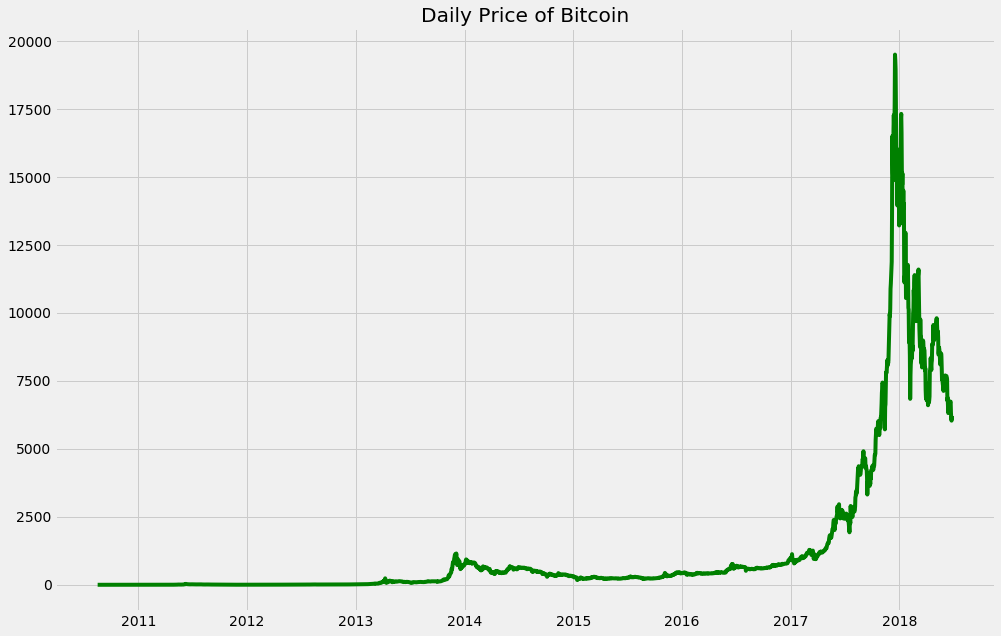

Results of Dickey-Fuller Test:
Test Statistic                   -1.863792
p-value                           0.349282
#Lags Used                       27.000000
Number of Observations Used    2843.000000
Critical Value (1%)              -3.432652
Critical Value (5%)              -2.862557
Critical Value (10%)             -2.567311
dtype: float64
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [700]:
adf_test(btc_price_df['BCHAIN/MKPRU'])

### Log transformation of the series 

In [701]:
btc_price_df["log_price"]=np.log(btc_price_df['BCHAIN/MKPRU'])

In [702]:
btc_price_df["log_price"].describe()

count    2871.000000
mean        4.788544
std         2.876800
min        -2.798522
25%         2.471146
50%         5.625569
75%         6.491899
max         9.878102
Name: log_price, dtype: float64

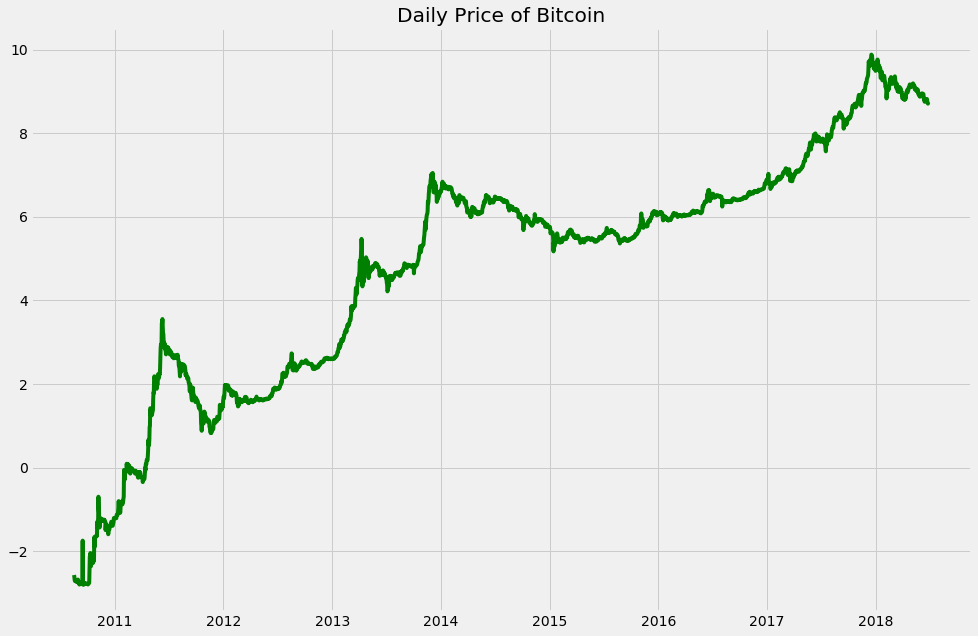

Results of Dickey-Fuller Test:
Test Statistic                   -2.570922
p-value                           0.099157
#Lags Used                       16.000000
Number of Observations Used    2854.000000
Critical Value (1%)              -3.432643
Critical Value (5%)              -2.862553
Critical Value (10%)             -2.567309
dtype: float64
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [703]:
adf_test(btc_price_df["log_price"]) 

 ### Decomposition after log transformation 

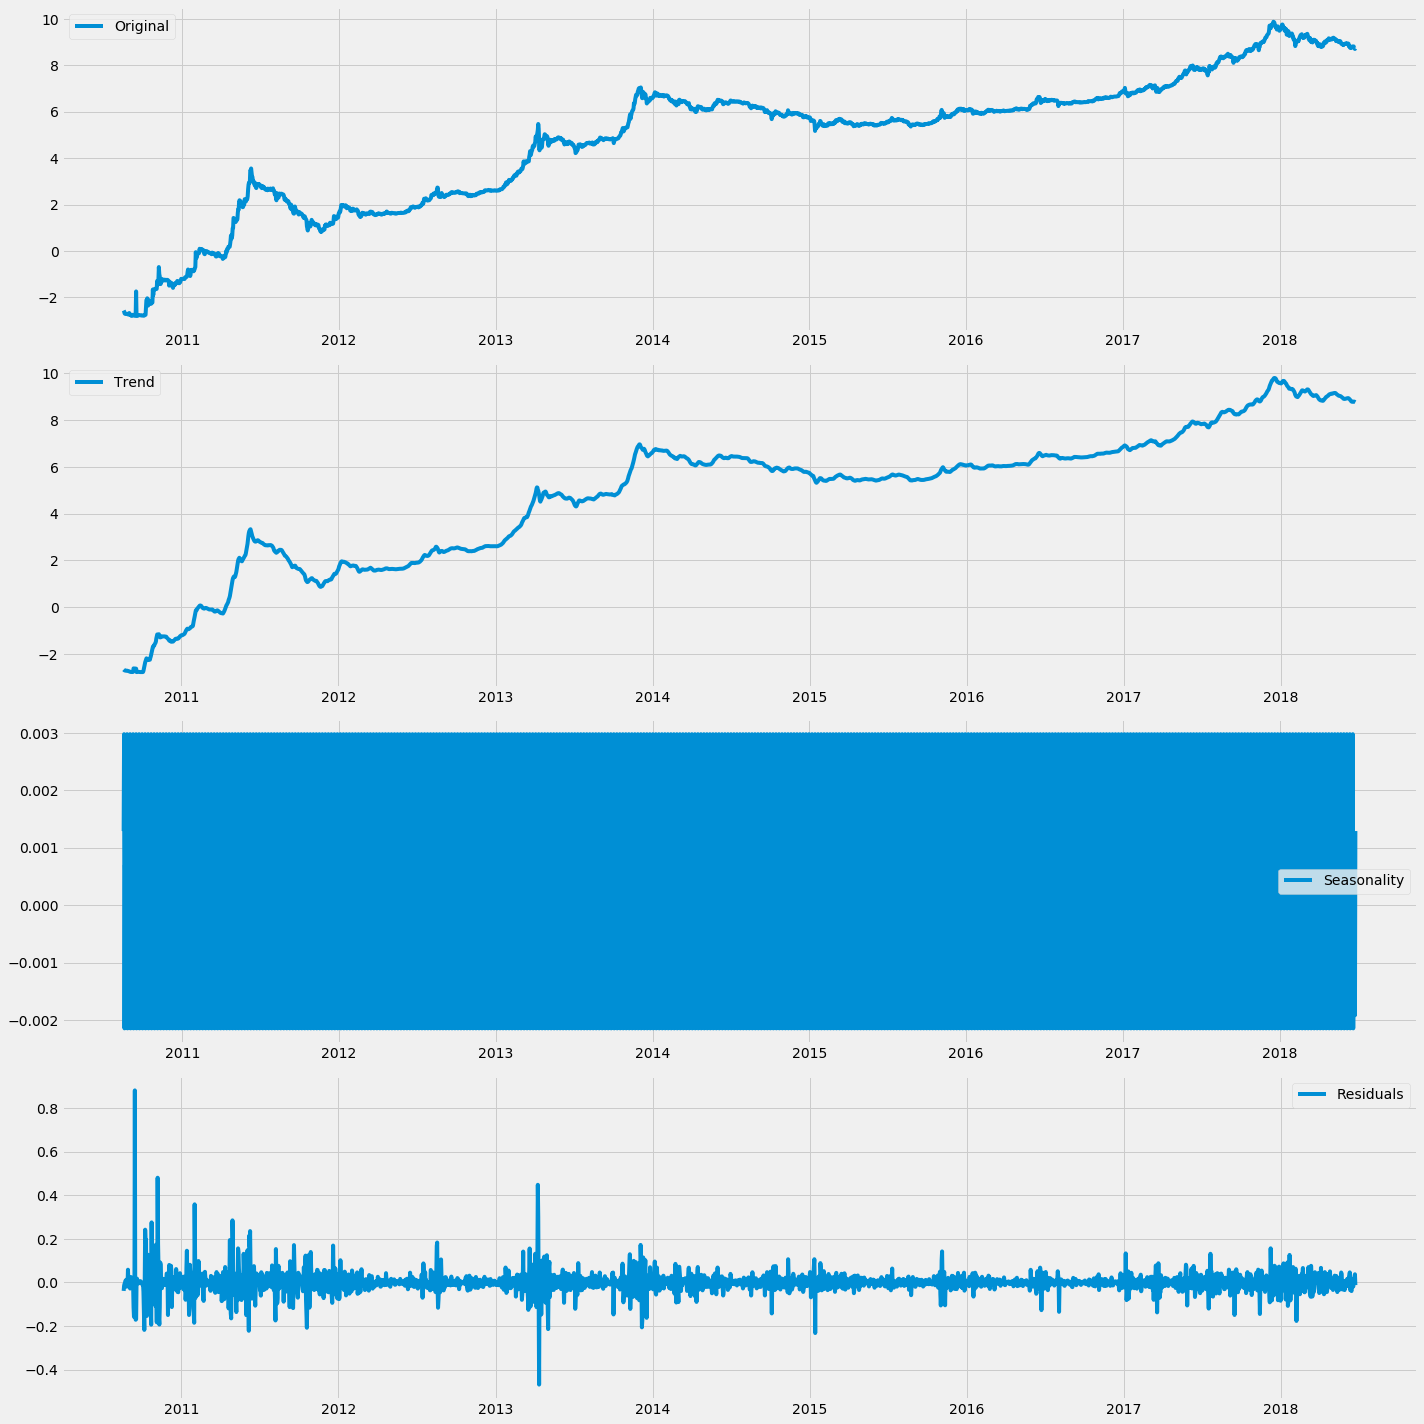

In [704]:
decomposition = seasonal_decompose(btc_price_df["log_price"], model='Multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig, ax=plt.subplots(figsize=(20,20))
plt.subplot(411)
plt.plot(btc_price_df["log_price"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### First Difference

In [705]:
btc_price_df["price_diff"]=btc_price_df["BCHAIN/MKPRU"].diff()

In [706]:
btc_price_df["price_diff"].dropna(axis=0, inplace=True)

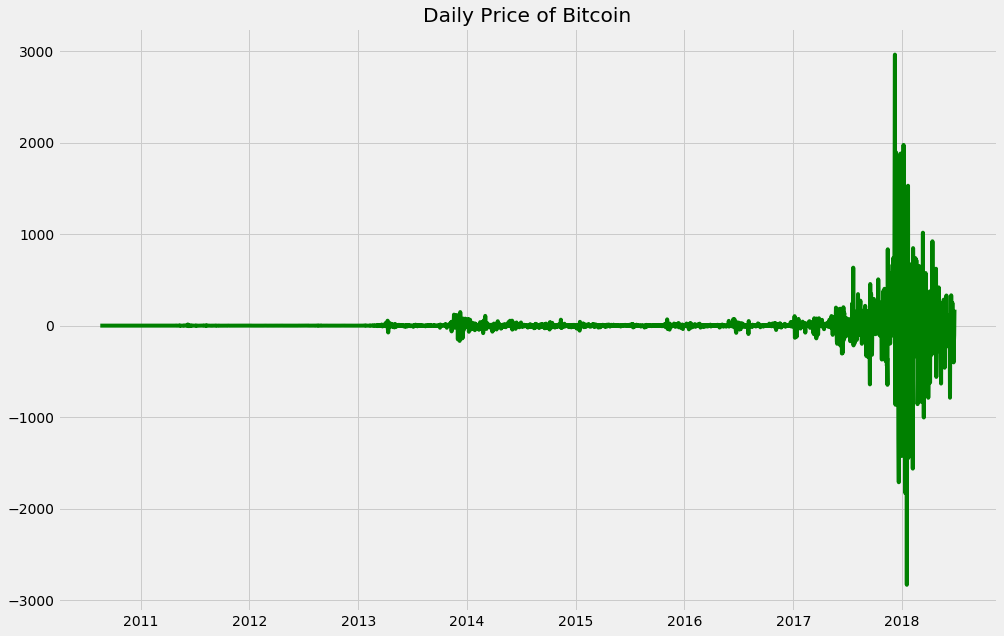

Results of Dickey-Fuller Test:
Test Statistic                -9.813783e+00
p-value                        5.566880e-17
#Lags Used                     2.800000e+01
Number of Observations Used    2.841000e+03
Critical Value (1%)           -3.432654e+00
Critical Value (5%)           -2.862558e+00
Critical Value (10%)          -2.567312e+00
dtype: float64
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [707]:
adf_test(btc_price_df["price_diff"])

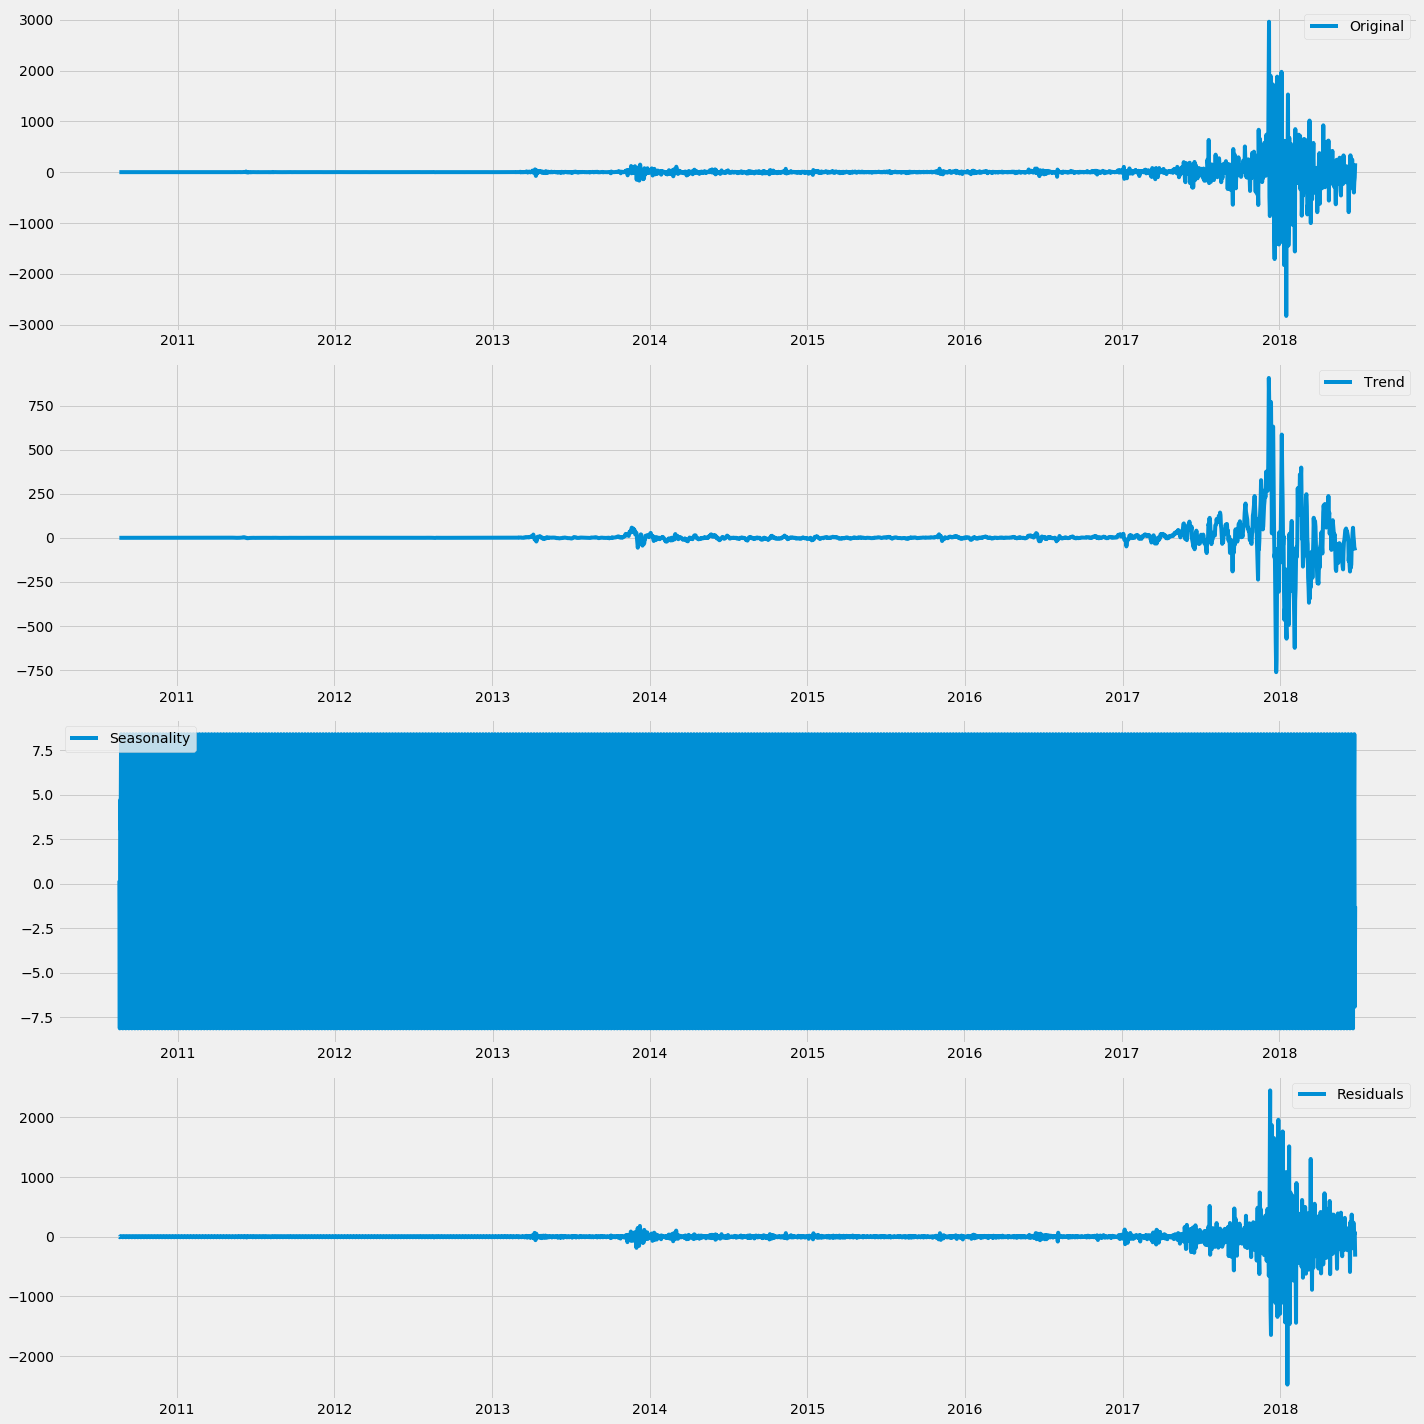

In [708]:
decomposition = seasonal_decompose(btc_price_df["price_diff"], model='Multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig, ax=plt.subplots(figsize=(20,20))
plt.subplot(411)
plt.plot(btc_price_df["price_diff"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [709]:
# #we can check the mean and variance ,if they are smoothed 
# X = btc_price_df["price_diff"].values
# split = int(len(X) / 2)
# X_1=X[0:split]
# X_2=X[split:]
# mean_1=X_1.mean() 
# mean_2= X_2.mean()
# var_1 = X_1.var()
# var_2= X_2.var()
# # print('mean1=%f, mean2=%f' % (mean1, mean2))
# # print('variance1=%f, variance2=%f' % (var1, var2))

### First Difference on log transformed 

In [710]:
btc_price_df["log_price_diff"]=btc_price_df["log_price"].diff()

In [711]:
btc_price_df["log_price_diff"].dropna(axis=0, inplace=True)

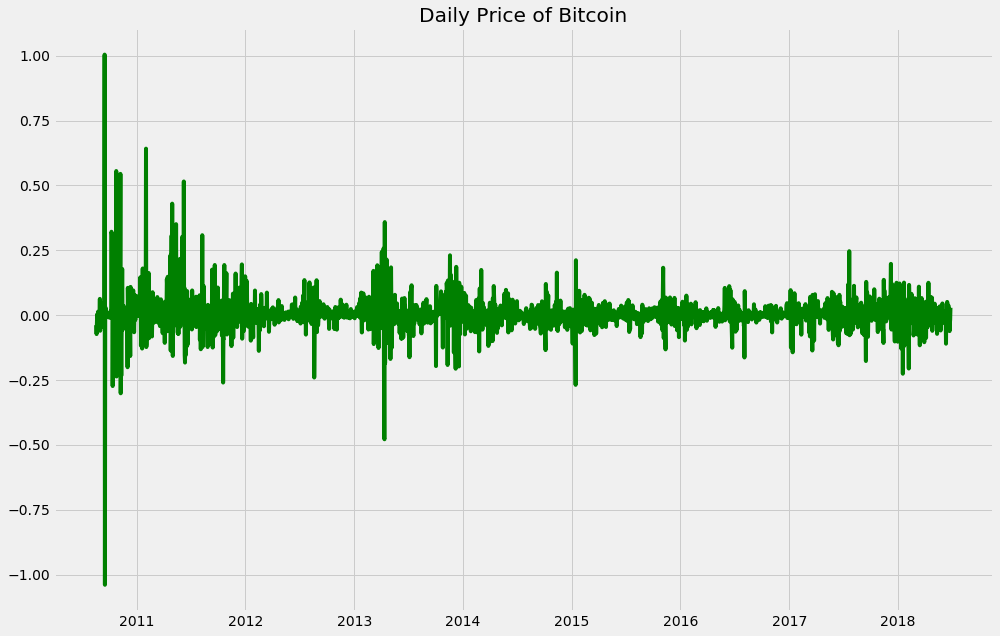

Results of Dickey-Fuller Test:
Test Statistic                -1.087471e+01
p-value                        1.340772e-19
#Lags Used                     1.500000e+01
Number of Observations Used    2.854000e+03
Critical Value (1%)           -3.432643e+00
Critical Value (5%)           -2.862553e+00
Critical Value (10%)          -2.567309e+00
dtype: float64
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [712]:
adf_test(btc_price_df["log_price_diff"])

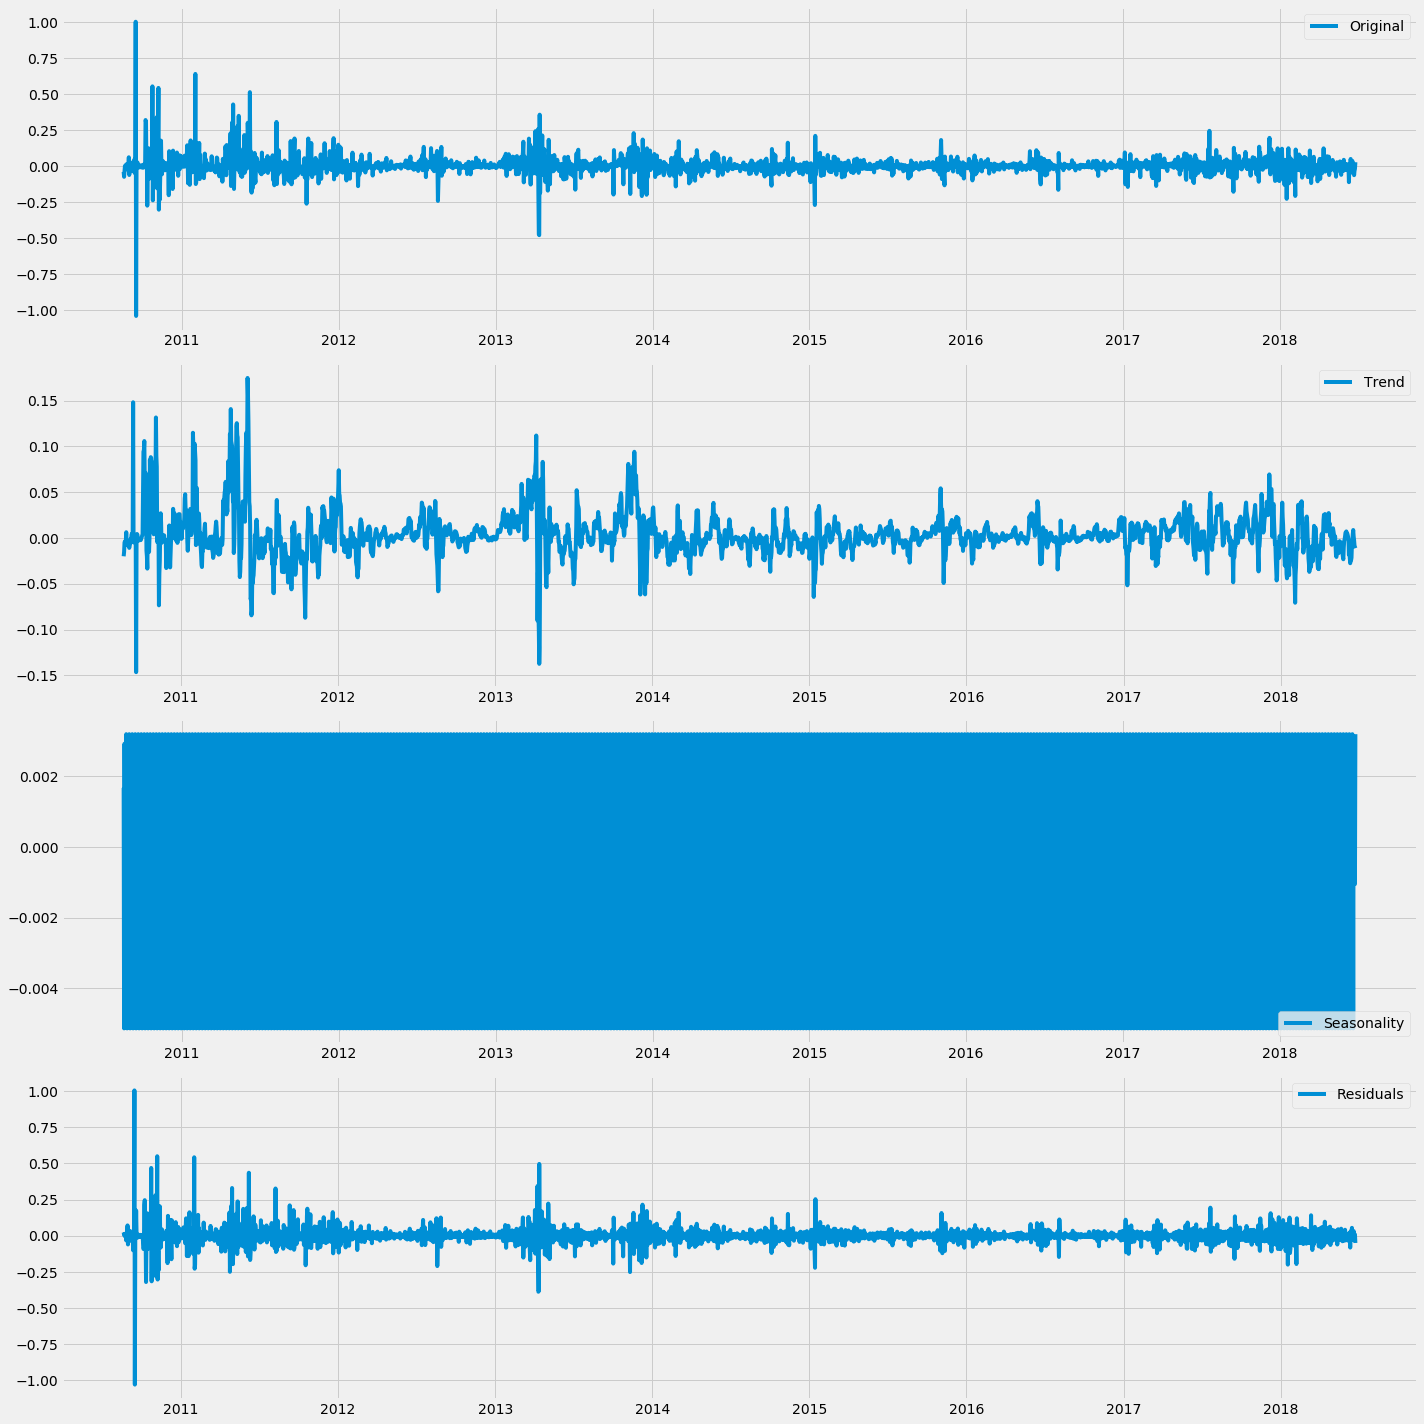

In [713]:
decomposition = seasonal_decompose(btc_price_df["log_price_diff"], model='Multiplicative')
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid
fig, ax=plt.subplots(figsize=(20,20))
plt.subplot(411)
plt.plot(btc_price_df["log_price_diff"], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [714]:
#we can check the mean and variance ,if they are smoothed 
X = btc_price_df["log_price_diff"].values
split = int(len(X) / 2)
X1=X[0:split]
X2=X[split:]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1=%f, mean2=%f' % (mean1, mean2))
print('variance1=%f, variance2=%f' % (var1, var2))

mean1=0.006269, mean2=0.001605
variance1=0.006556, variance2=0.001552


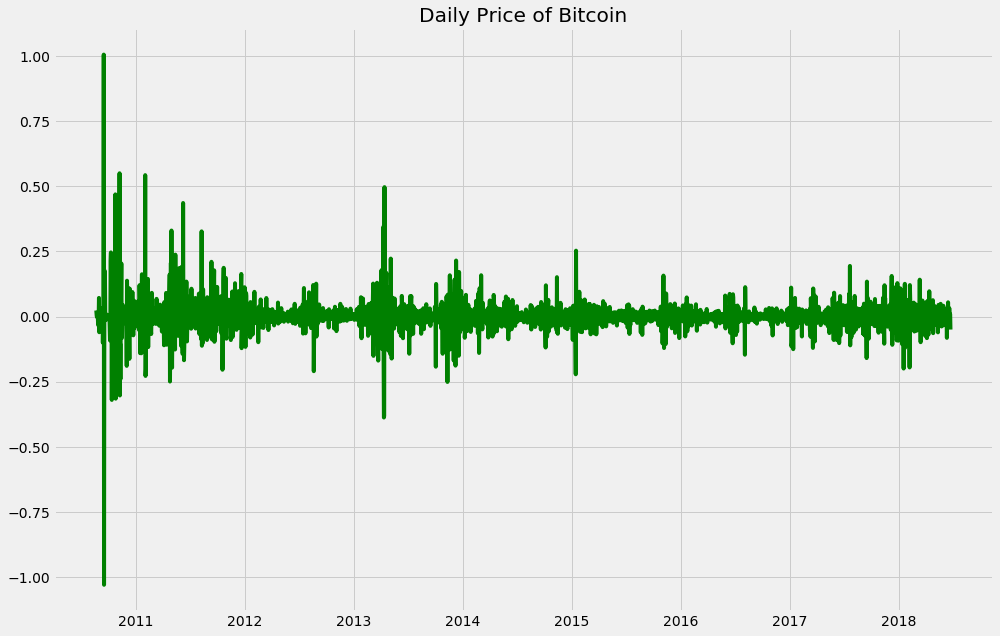

Results of Dickey-Fuller Test:
Test Statistic                  -22.140295
p-value                           0.000000
#Lags Used                       28.000000
Number of Observations Used    2835.000000
Critical Value (1%)              -3.432659
Critical Value (5%)              -2.862560
Critical Value (10%)             -2.567313
dtype: float64
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [715]:
#Here we can see that the trend, seasonality are separated out from data and we can model the residuals. Lets check stationarity of residuals:
decom_resid = residual
decom_resid.dropna(inplace=True)
adf_test(decom_resid)

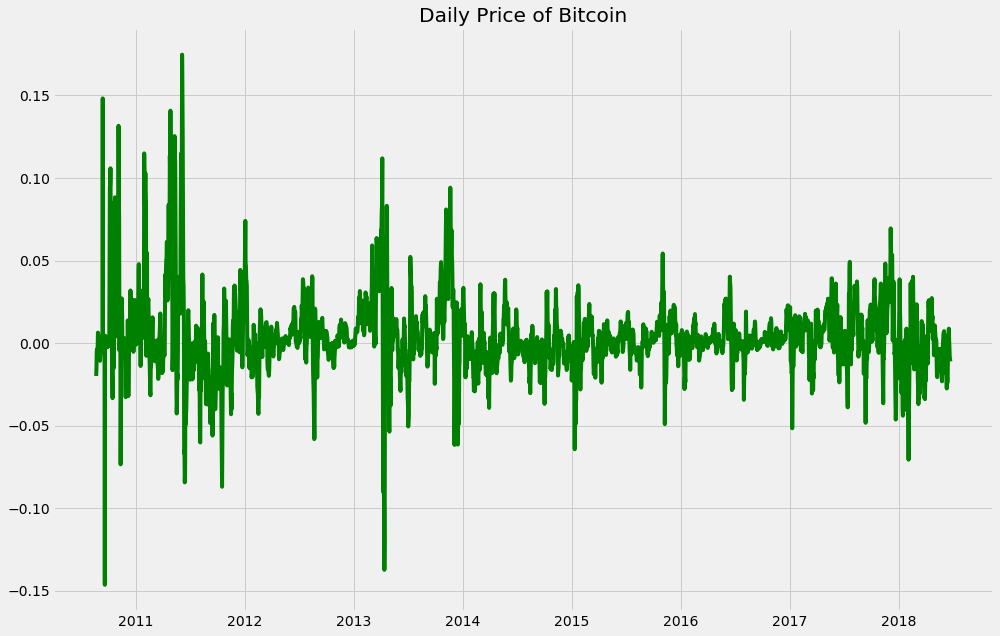

Results of Dickey-Fuller Test:
Test Statistic                -6.849026e+00
p-value                        1.713140e-09
#Lags Used                     2.800000e+01
Number of Observations Used    2.835000e+03
Critical Value (1%)           -3.432659e+00
Critical Value (5%)           -2.862560e+00
Critical Value (10%)          -2.567313e+00
dtype: float64
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [716]:
decom_trend = trend
decom_trend.dropna(inplace=True)
adf_test(decom_trend)
# There was a trend stationarity and eliminated after the first difference

### Checking for Serial Correlation: Ljung Box test

Once we have a stationary time series we will check for serial correlation. We will use Ljung Box test . The Ljung–Box test may be defined as:
H0: The data are independently distributed (i.e. the correlations in the population from which the sample is taken are 0, so that any observed correlations in the data result from randomness of the sampling process).
Ha: The data are not independently distributed; they exhibit serial correlation.

A small  p value shows significant autocorrelation.  

If there is a serial correlation we will employ PCAF and ACF. 

In [717]:
Ljung_Box=acorr_ljungbox(btc_price_df["log_price_diff"], lags=10, boxpierce=False)
data = list(Ljung_Box)
data=pd.DataFrame(data)
data=(data.T)
data.columns=['Test Statistic', 'p-value']
data 

,Test Statistic,p-value
0,6.357870,0.011686
1,7.166115,0.027791
2,7.991840,0.046181
3,9.111749,0.058366
4,12.347839,0.030320
5,28.443548,0.000078
6,29.061436,0.000141
7,33.403672,0.000052
8,33.418007,0.000113
9,39.776243,0.000019


At the α=0.05 significance level, the null hypothesis of no autocorrelation is rejected at all  lags.The conclusion is that there is significant autocorrelation in the series.

### Eliminating Serial Correlation(Determining ARIMA order)

In [718]:
btc_acf=acf(btc_price_df["log_price_diff"], nlags=40)
btc_pacf=pacf(btc_price_df["log_price_diff"], nlags=40)

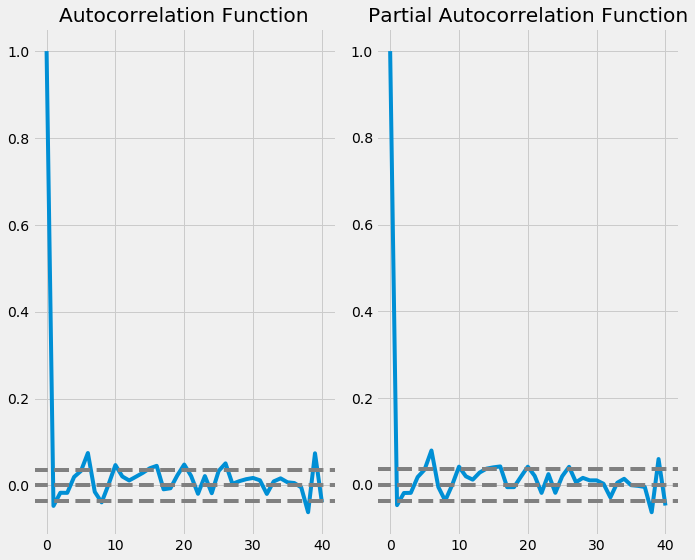

In [719]:
#Plot ACF: 
fig, ax=plt.subplots(figsize=(10,8))
plt.subplot(121) 
plt.plot(btc_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(btc_price_df["log_price_diff"])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(btc_price_df["log_price_diff"])),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF: 
plt.subplot(122)
plt.plot(btc_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(btc_price_df["log_price_diff"])),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(btc_price_df["log_price_diff"])),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [720]:
btc_price_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2871 entries, 2010-08-17 to 2018-06-26
Freq: D
Data columns (total 4 columns):
BCHAIN/MKPRU      2871 non-null float64
log_price         2871 non-null float64
price_diff        2870 non-null float64
log_price_diff    2870 non-null float64
dtypes: float64(4)
memory usage: 112.1 KB


In [721]:
from datetime import date

d0 = date(2018, 6, 19)
d1 = date(2018, 6, 26)
delta = d1 - d0
print (delta.days)

7


# ARIMA modeling on Training data set

In [722]:
train =btc_price_df.loc['2010-08-17':'2018-06-19']
test = btc_price_df.loc['2018-06-20':]

len(train) #Try by reducing the test data size

2864

In [723]:
train.dropna(inplace=True)
test.dropna(inplace=True)

c:\users\getud\dropbox\dereje~1\nssds~1\test\venvtest\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
c:\users\getud\dropbox\dereje~1\nssds~1\test\venvtest\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


### Estimation on the AR(6) Model

In [724]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7 entries, 2018-06-20 to 2018-06-26
Freq: D
Data columns (total 4 columns):
BCHAIN/MKPRU      7 non-null float64
log_price         7 non-null float64
price_diff        7 non-null float64
log_price_diff    7 non-null float64
dtypes: float64(4)
memory usage: 280.0 bytes


In [725]:
#fig, ax=plt.subplots(figsize=(15,15))
model=ARIMA(train["log_price"], order=(6,1,0))
results_AR= model.fit(disp=-1)
#plt.plot(train["log_price_diff"])
#plt.plot(results_ARIMA.fittedvalues, color='red', label="fitted_value")
rs=results_AR.fittedvalues-train["log_price_diff"]
rs.dropna(inplace=True)
rss=sum((rs)**2)
#plt.title(('RSS: %.4f'% rss))
print(rss)

11.516617161660342


In [726]:
print(results_AR.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.log_price   No. Observations:                 2862
Model:                 ARIMA(6, 1, 0)   Log Likelihood                3831.642
Method:                       css-mle   S.D. of innovations              0.063
Date:                Fri, 20 Jul 2018   AIC                          -7647.285
Time:                        07:24:22   BIC                          -7599.610
Sample:                    08-19-2010   HQIC                         -7630.095
                         - 06-19-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0040      0.001      3.192      0.001       0.002       0.006
ar.L1.D.log_price    -0.0519      0.019     -2.786      0.005      -0.088      -0.015
ar.L2.D.log_price    -0.

Text(0.5,1,'RSS: 11.5166')

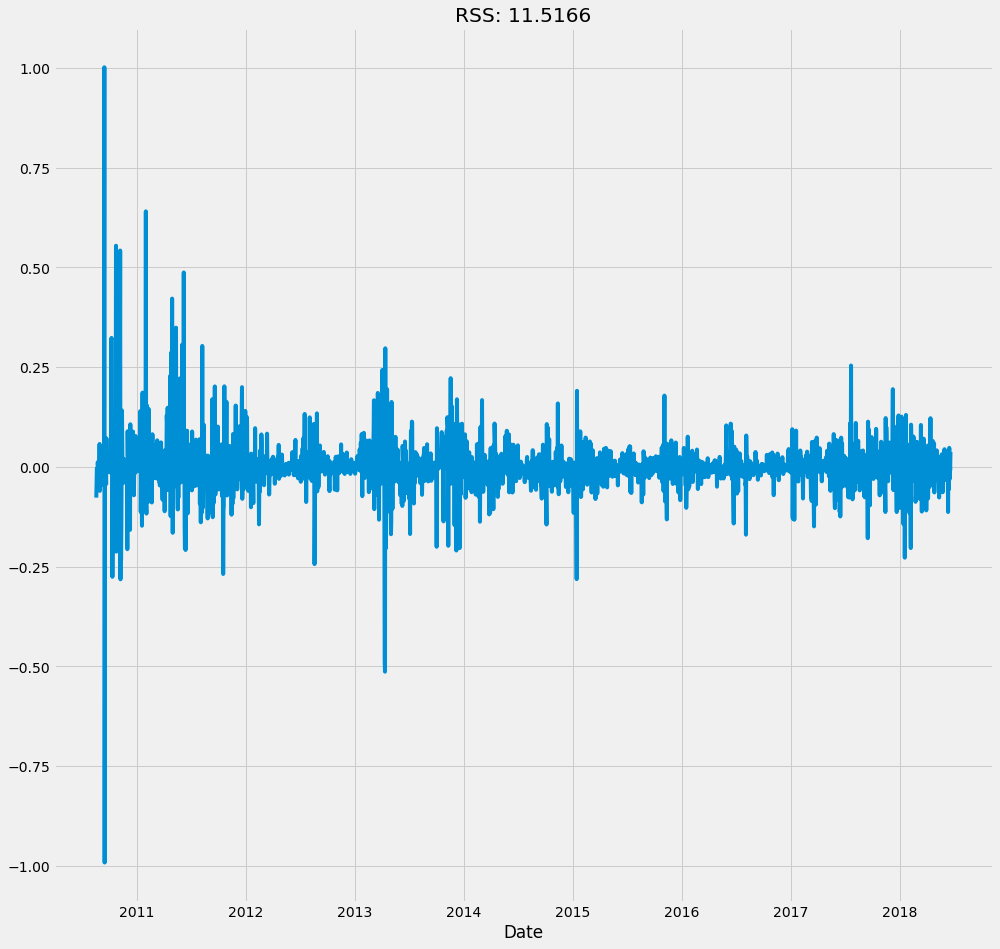

In [727]:
fig, ax=plt.subplots(figsize=(15,15))
results_AR.resid.plot()
plt.title(('RSS: %.4f'% rss))

Text(0.5,1,'Density plot of the residual error values')

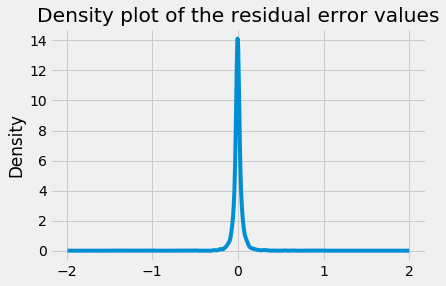

In [728]:
results_AR.resid.plot(kind='kde')
plt.title('Density plot of the residual error values')

In [729]:
fitted_AR=pd.Series(results_AR.fittedvalues, copy=True)

In [730]:
fitted_AR.head()

Date
2010-08-19    0.003985
2010-08-20    0.007643
2010-08-21    0.007164
2010-08-22    0.006173
2010-08-23    0.003808
Freq: D, dtype: float64

In [731]:
fitted_AR_cumsum=fitted_AR.cumsum()

In [732]:
fitted_AR_cumsum.head()

Date
2010-08-19    0.003985
2010-08-20    0.011628
2010-08-21    0.018792
2010-08-22    0.024965
2010-08-23    0.028773
Freq: D, dtype: float64

In [733]:
fitted_AR_log=pd.Series(train["log_price"].iloc[0], index=train["log_price"].index)

In [734]:
fitted_AR_log.head()

Date
2010-08-18   -2.60369
2010-08-19   -2.60369
2010-08-20   -2.60369
2010-08-21   -2.60369
2010-08-22   -2.60369
Freq: D, dtype: float64

In [735]:
fitted_AR_log_add=fitted_AR_log.add(fitted_AR_cumsum, fill_value=0)

In [736]:
fitted_AR_log_add.head()

Date
2010-08-18   -2.603690
2010-08-19   -2.599705
2010-08-20   -2.592062
2010-08-21   -2.584898
2010-08-22   -2.578725
Freq: D, dtype: float64

In [737]:
fitted_price_AR=np.exp(fitted_AR_log_add)

In [738]:
fitted_price_AR.describe()

count    2863.000000
mean      602.735552
std      1308.218311
min         0.074000
25%         1.406441
50%        26.302380
75%       392.816181
max      6680.511840
dtype: float64

In [739]:
fitted_price_AR.tail()

Date
2018-06-15    6680.511840
2018-06-16    6667.883801
2018-06-17    6639.628954
2018-06-18    6649.648956
2018-06-19    6650.704451
Freq: D, dtype: float64

Text(0.5,1,'RMSE: 1918.2793')

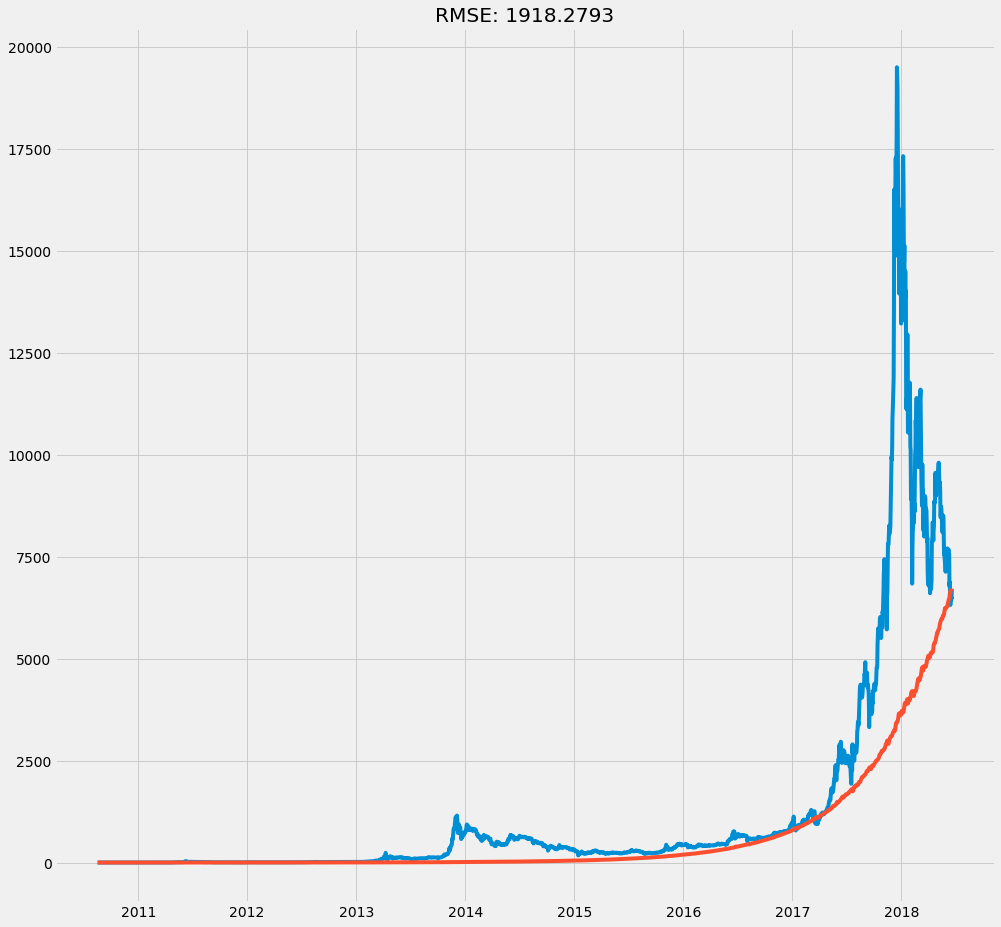

In [740]:
fig, ax=plt.subplots(figsize=(15,15))

plt.plot(train['BCHAIN/MKPRU'])
plt.plot(fitted_price_AR)
plt.title('RMSE: %.4f'% np.sqrt(sum((fitted_price_AR-train['BCHAIN/MKPRU'])**2)/len(train['BCHAIN/MKPRU'])))

In [741]:
#results_ARIMA.predict(1,2870)

In [742]:
# from pandas import read_csv
# from pandas import datetime
# from matplotlib import pyplot
# from statsmodels.tsa.arima_model import ARIMA
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# # load dataset
# train =btc_price_df["log_price"].loc['2010-08-17':'2017-12-31']
# test = btc_price_df["log_price"].loc['2018-01-01':]
# # train = btc_price_df["log_price"][:"2016-12-31"]
# # test = btc_price_df["log_price"]["2017-01-01":]
# history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
#     # fit model
#     model = ARIMA(history, order=(1,1,1))
#     model_fit = model.fit(disp=-1, trend='c')
#     print(model_fit.params)
#     # one step forecast
#     yhat = model_fit.forecast()[0]
#     # store forecast and ob
#     predictions.append(yhat)
#     history.append(test[t])
# # evaluate forecasts
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)

### MA(6)

In [743]:
#fig, ax=plt.subplots(figsize=(15,15))
model=ARIMA(train["log_price"], order=(0,1,6))
results_MA= model.fit(disp=-1)
#plt.plot(train["log_price_diff"])
#plt.plot(results_ARIMA.fittedvalues, color='red', label="fitted_value")
rs=results_MA.fittedvalues-train["log_price_diff"]
rs.dropna(inplace=True)
rss=sum((rs)**2)
#plt.title(('RSS: %.4f'% rss))
print(rss)

11.53006759592194


In [744]:
print(results_MA.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.log_price   No. Observations:                 2862
Model:                 ARIMA(0, 1, 6)   Log Likelihood                3829.975
Method:                       css-mle   S.D. of innovations              0.063
Date:                Fri, 20 Jul 2018   AIC                          -7643.950
Time:                        07:24:24   BIC                          -7596.276
Sample:                    08-19-2010   HQIC                         -7626.761
                         - 06-19-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0040      0.001      3.215      0.001       0.002       0.006
ma.L1.D.log_price    -0.0490      0.019     -2.633      0.009      -0.086      -0.013
ma.L2.D.log_price    -0.

Text(0.5,1,'RSS: 11.5301')

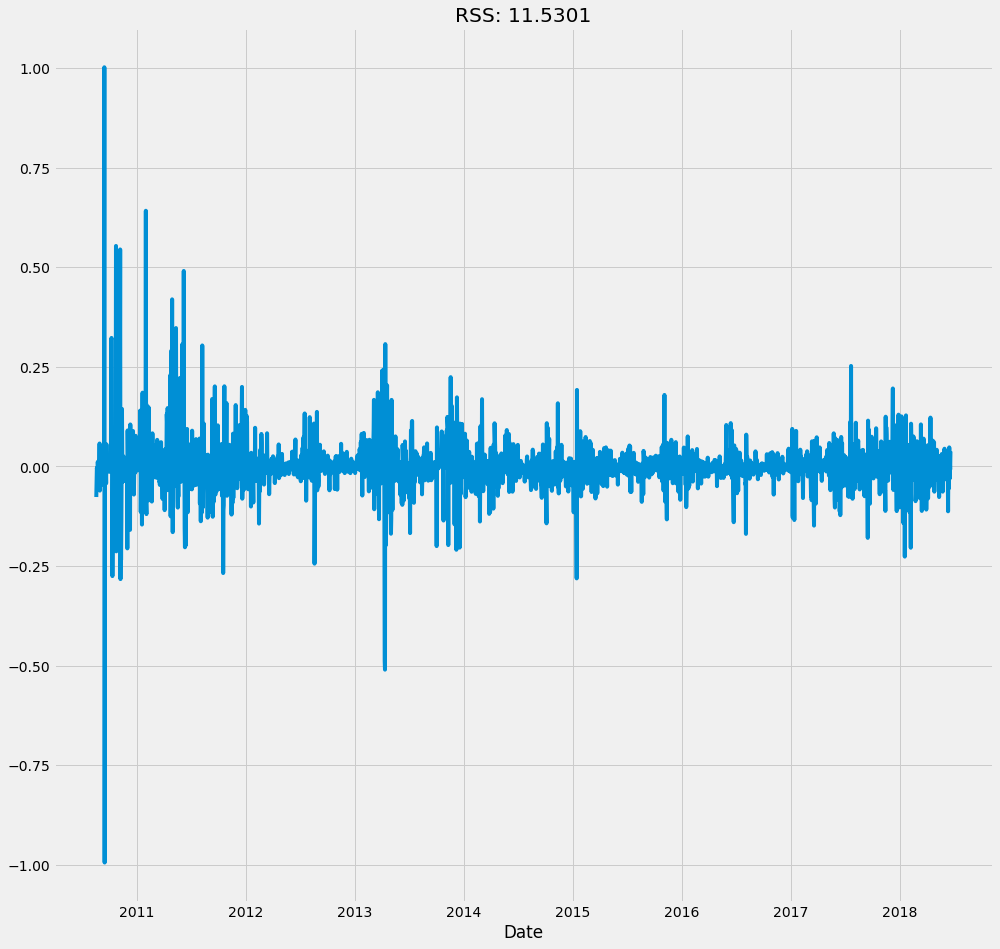

In [745]:
fig, ax=plt.subplots(figsize=(15,15))
results_MA.resid.plot()
plt.title(('RSS: %.4f'% rss))

Text(0.5,1,'Density plot of the residual error values')

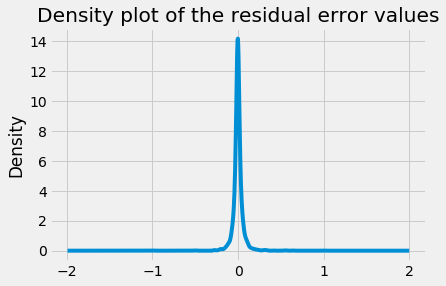

In [746]:
results_MA.resid.plot(kind='kde')
plt.title('Density plot of the residual error values')

Text(0.5,1,'RMSE: 1922.5417')

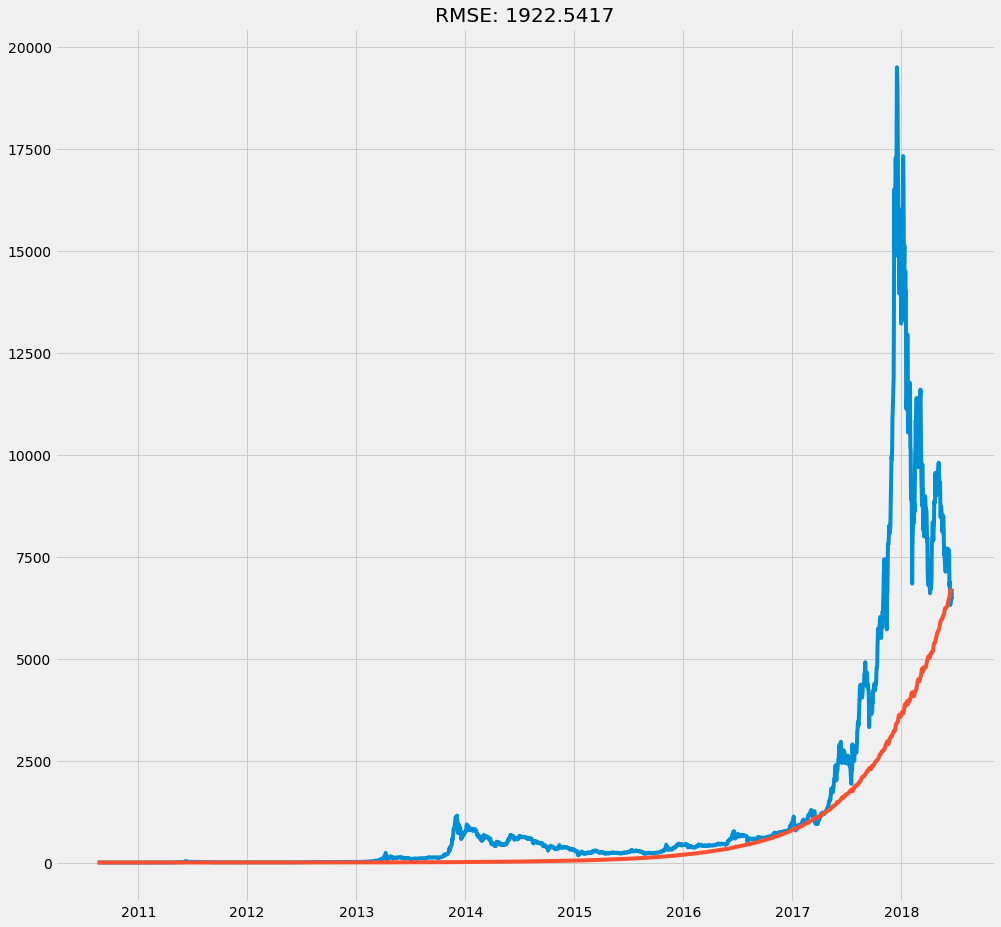

In [747]:
fitted_MA=pd.Series(results_MA.fittedvalues, copy=True)
fitted_MA_cumsum=fitted_MA.cumsum()
fitted_MA_log=pd.Series(train["log_price"].iloc[0], index=train["log_price"].index)
fitted_MA_log_add=fitted_MA_log.add(fitted_MA_cumsum, fill_value=0)
fitted_price_MA=np.exp(fitted_MA_log_add)

fig, ax=plt.subplots(figsize=(15,15))

plt.plot(train['BCHAIN/MKPRU'])
plt.plot(fitted_price_MA)
plt.title('RMSE: %.4f'% np.sqrt(sum((fitted_price_MA-train['BCHAIN/MKPRU'])**2)/len(train['BCHAIN/MKPRU'])))

In [748]:
#fig, ax=plt.subplots(figsize=(15,15))
model=ARIMA(train["log_price"], order=(6,1,6))
results_ARIMA= model.fit(disp=-1)
#plt.plot(train["log_price_diff"])
#plt.plot(results_ARIMA.fittedvalues, color='red', label="fitted_value")
rs=results_ARIMA.fittedvalues-train["log_price_diff"]
rs.dropna(inplace=True)
rss=sum((rs)**2)
#plt.title(('RSS: %.4f'% rss))
print(rss)

11.423808142546935


In [749]:
print(results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.log_price   No. Observations:                 2862
Model:                 ARIMA(6, 1, 6)   Log Likelihood                3843.319
Method:                       css-mle   S.D. of innovations              0.063
Date:                Fri, 20 Jul 2018   AIC                          -7658.638
Time:                        07:24:52   BIC                          -7575.208
Sample:                    08-19-2010   HQIC                         -7628.556
                         - 06-19-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0039      0.002      2.286      0.022       0.001       0.007
ar.L1.D.log_price     0.2703      0.274      0.986      0.324      -0.267       0.807
ar.L2.D.log_price    -0.

Text(0.5,1,'RSS: 11.4238')

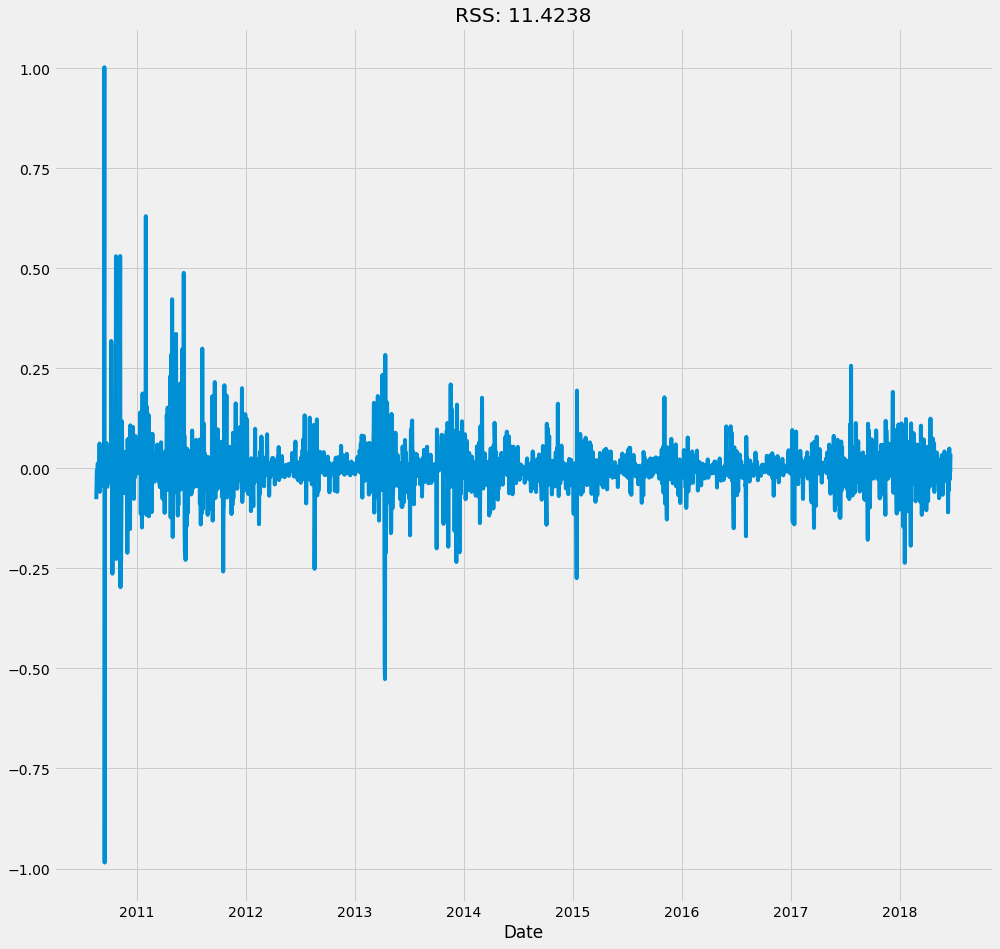

In [750]:
fig, ax=plt.subplots(figsize=(15,15))
results_ARIMA.resid.plot()
plt.title(('RSS: %.4f'% rss))

Text(0.5,1,'Density plot of the residual error values')

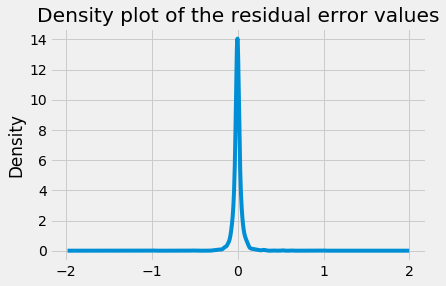

In [751]:
results_ARIMA.resid.plot(kind='kde')
plt.title('Density plot of the residual error values')

Text(0.5,1,'RMSE: 1782.7938')

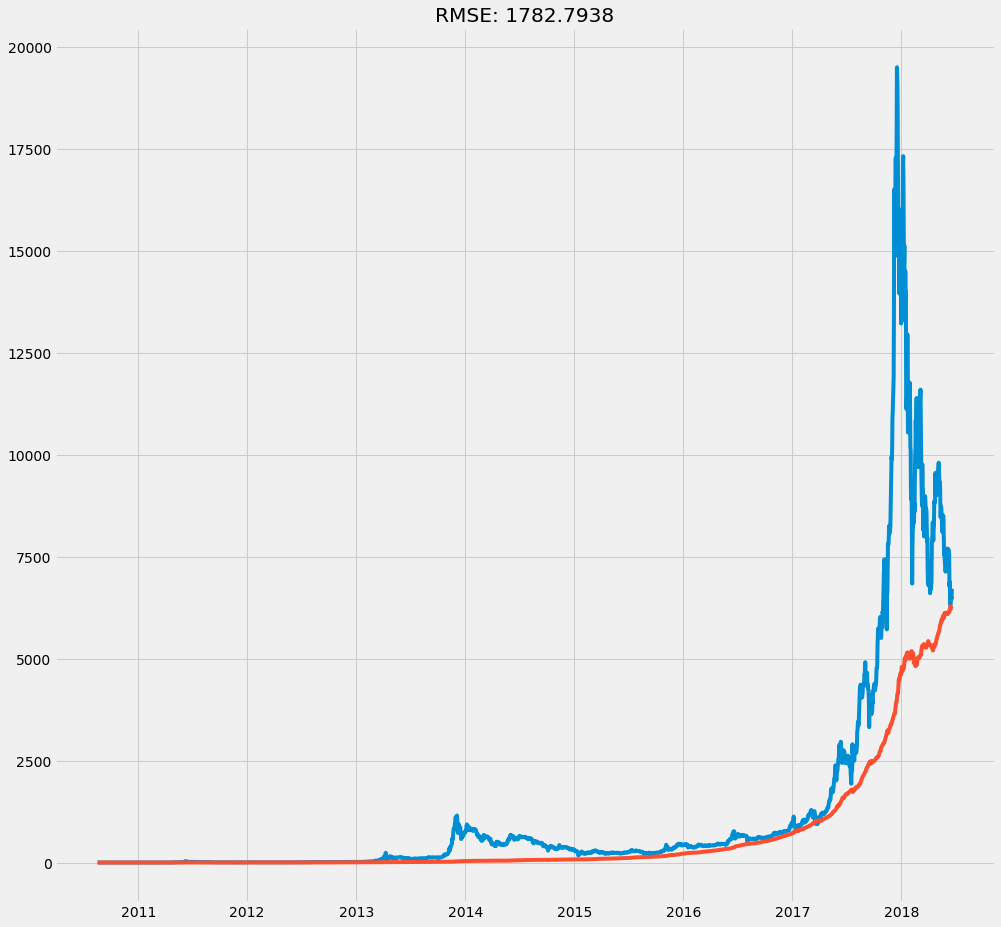

In [752]:
fitted_ARIMA=pd.Series(results_ARIMA.fittedvalues, copy=True)
fitted_ARIMA_cumsum=fitted_ARIMA.cumsum()
fitted_ARIMA_log=pd.Series(train["log_price"].iloc[0], index=train["log_price"].index)
fitted_ARIMA_log_add=fitted_ARIMA_log.add(fitted_ARIMA_cumsum, fill_value=0)
fitted_price_ARIMA=np.exp(fitted_ARIMA_log_add)

fig, ax=plt.subplots(figsize=(15,15))

plt.plot(train['BCHAIN/MKPRU'])
plt.plot(fitted_price_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((fitted_price_ARIMA-train['BCHAIN/MKPRU'])**2)/len(train['BCHAIN/MKPRU'])))

# ARIMA Model on Full data set 

Text(0.5,1,'RSS: 11.4229')

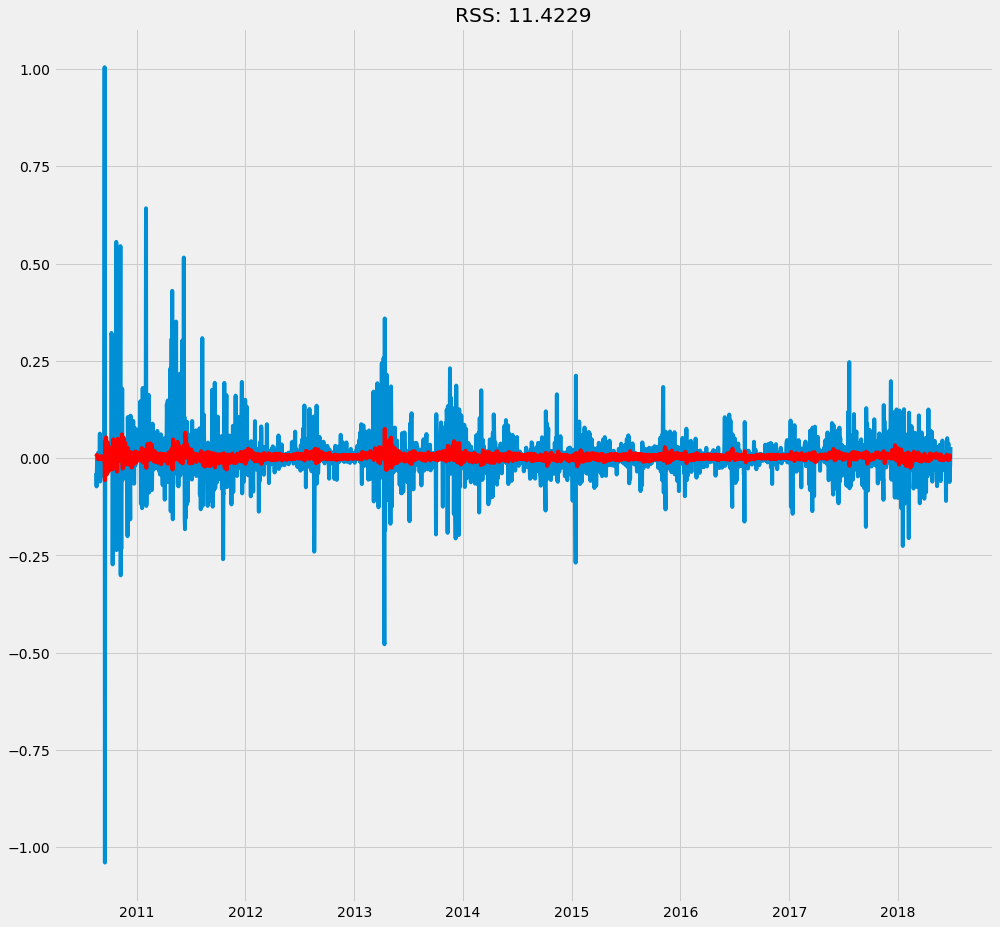

In [753]:
fig, ax=plt.subplots(figsize=(15,15))
full_model=ARIMA(btc_price_df["log_price"], order=(6,1,6))
full_results_ARIMA= full_model.fit(disp=-1)
plt.plot(btc_price_df["log_price_diff"])
plt.plot(full_results_ARIMA.fittedvalues, color='red')
full_rss=full_results_ARIMA.fittedvalues - btc_price_df["log_price_diff"]
full_rss.dropna(inplace=True)
plt.title(('RSS: %.4f'% sum((full_rss)**2)))
#plt.legend(loc = 'best')

In [754]:
print(full_results_ARIMA.summary())

                             ARIMA Model Results                              
Dep. Variable:            D.log_price   No. Observations:                 2870
Model:                 ARIMA(6, 1, 6)   Log Likelihood                3860.122
Method:                       css-mle   S.D. of innovations              0.063
Date:                Fri, 20 Jul 2018   AIC                          -7692.244
Time:                        07:25:56   BIC                          -7608.775
Sample:                    08-18-2010   HQIC                         -7662.153
                         - 06-26-2018                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 0.0039      0.002      2.252      0.024       0.000       0.007
ar.L1.D.log_price     0.1579      0.176      0.896      0.370      -0.187       0.503
ar.L2.D.log_price    -0.

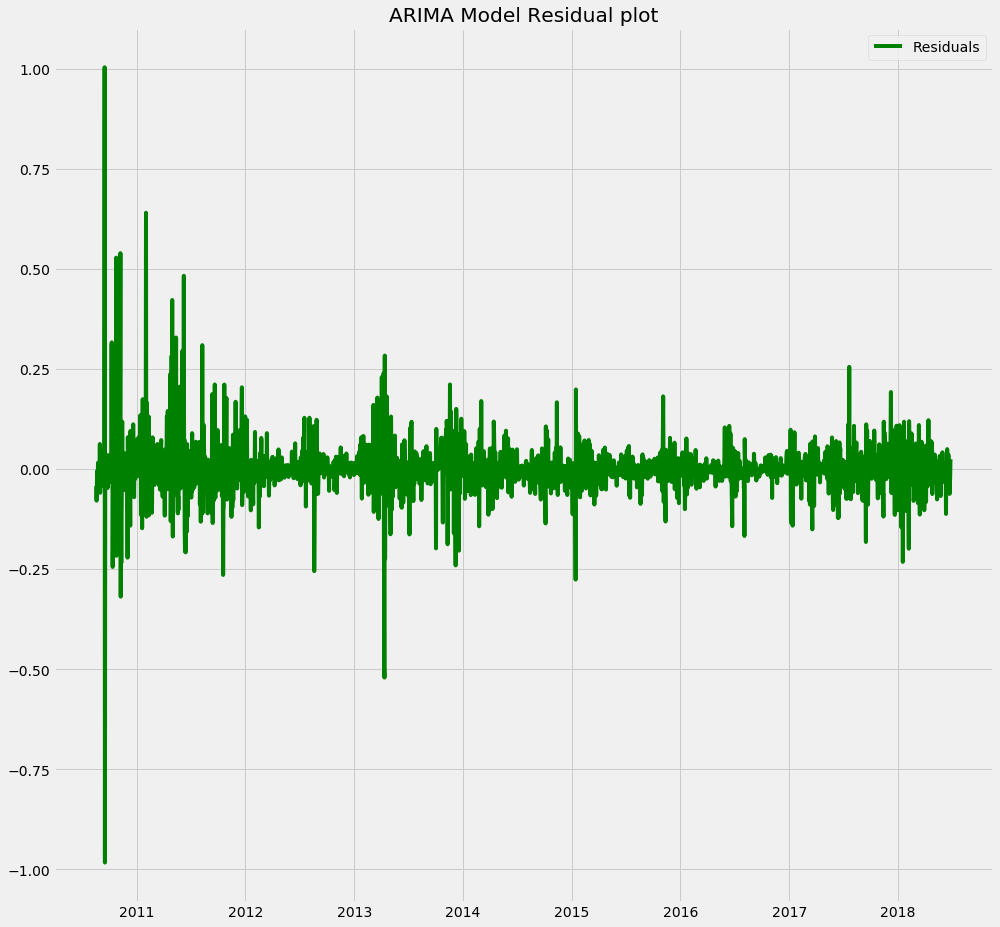

In [800]:
fig, ax=plt.subplots(figsize=(15,15))

#plt.plot(btc_price_df["log_price"], label = 'log price')
plt.plot(full_results_ARIMA.resid, color ='green',label= 'Residuals')
plt.title('ARIMA Model Residual plot')
plt.legend(loc = 'best')

Text(0.5,1,'Density plot of the residual error values')

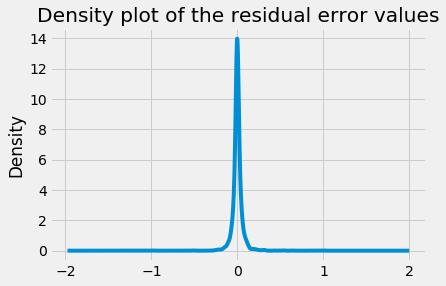

In [756]:
full_results_ARIMA.resid.plot(kind='kde')
plt.title('Density plot of the residual error values')

Text(0.5,1,'RMSE: 1884.3153')

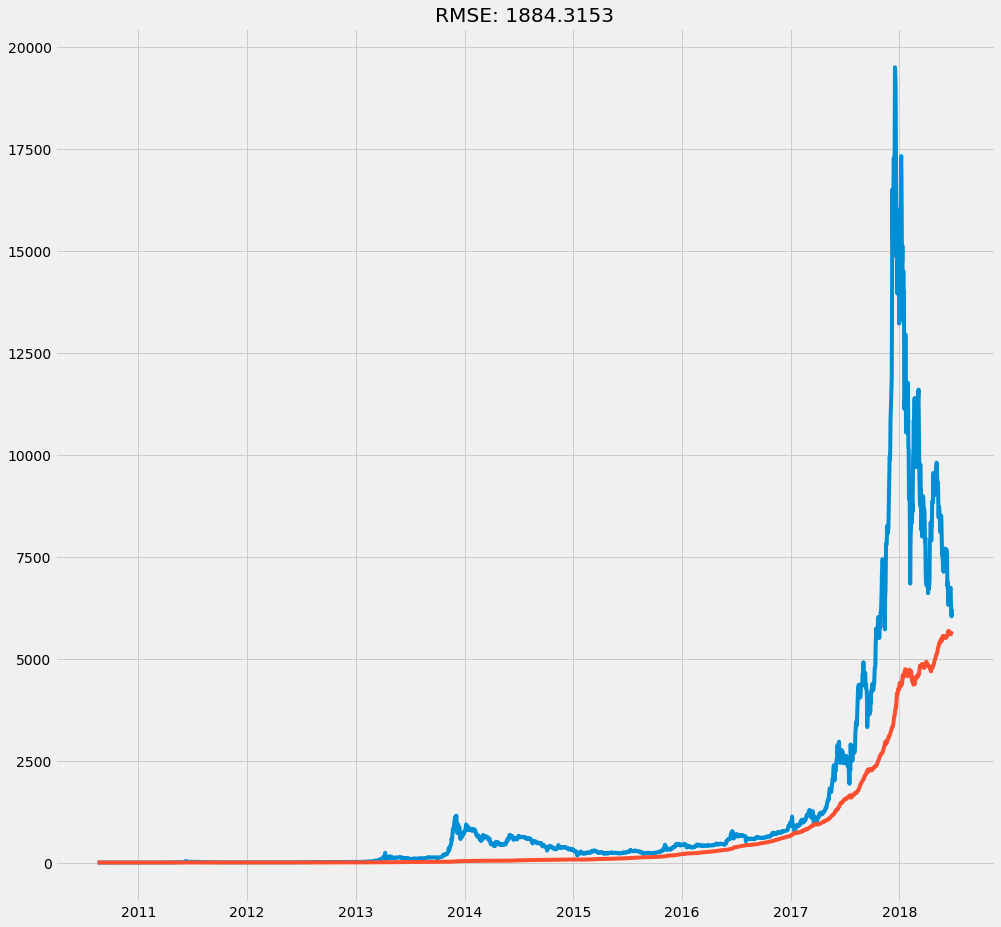

In [757]:
full_ARIMA=pd.Series(full_results_ARIMA.fittedvalues, copy=True)
full_ARIMA_cumsum=full_ARIMA.cumsum()
full_ARIMA_log=pd.Series(btc_price_df["log_price"].iloc[0], index=btc_price_df["log_price"].index)
full_ARIMA_log_add=full_ARIMA_log.add(full_ARIMA_cumsum, fill_value=0)
full_price_ARIMA=np.exp(full_ARIMA_log_add)

fig, ax=plt.subplots(figsize=(15,15))

plt.plot(btc_price_df['BCHAIN/MKPRU'])
plt.plot(full_price_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((full_price_ARIMA-btc_price_df['BCHAIN/MKPRU'])**2)/len(btc_price_df['BCHAIN/MKPRU'])))

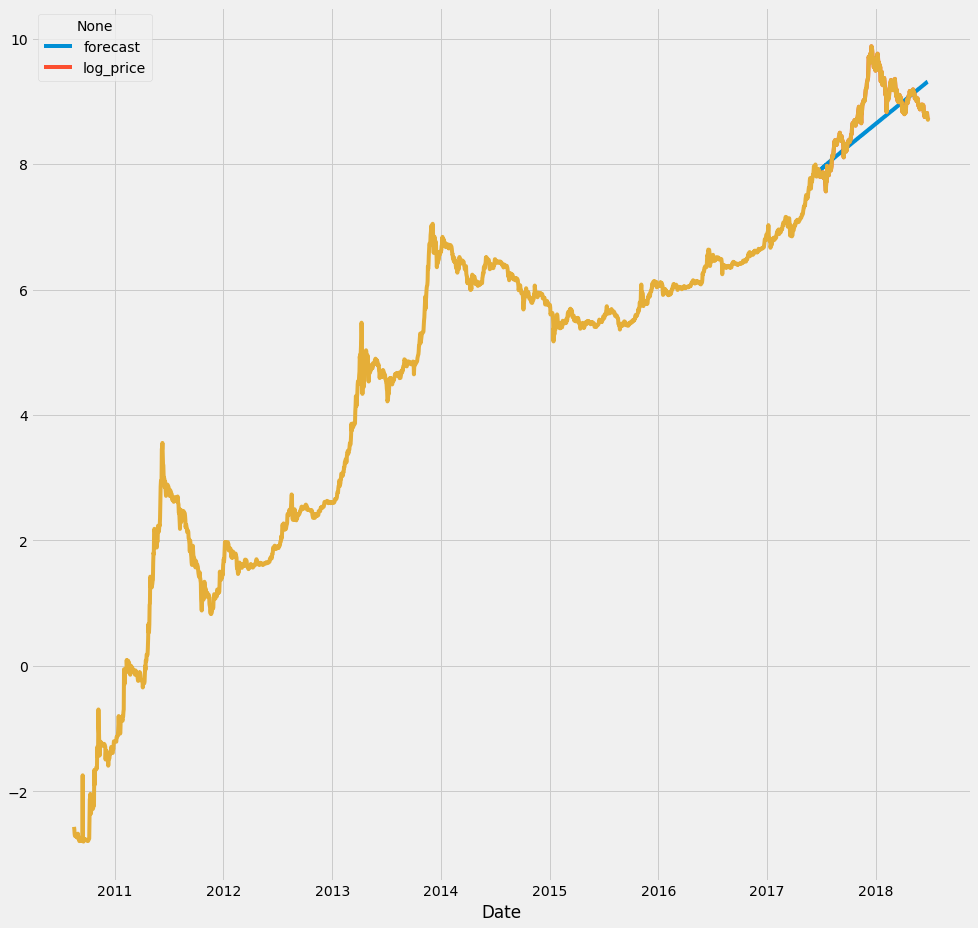

In [758]:
fig, ax=plt.subplots(figsize=(15,15))
full_results_ARIMA.plot_predict(start=2500, end=2868, ax=ax, dynamic=True, alpha=0.05)
btc_price_df['log_price'].plot(ax=ax)

In [759]:
# def evaluate_arima_model(data_set, arima_order):
#     model = ARIMA(data_set, order=arima_order) 
#     results_ARIMA = model.fit(disp=-1) 
#     RSS_diff = results_ARIMA.fittedvalues-btc_price_df["log_price_diff"]
#     RSS = RSS_diff**2 
#     return RSS 
# def evaluate_models(dataset, p_values, d_values): 
#     best_score, best_cfg = float("inf"), None 
#     for p in p_values: 
#         for d in d_values: 
#             order = (p,d,18) 
#         try: rss = evaluate_arima_model(dataset, order) 
#         if rss < best_score: 
#                 best_score, best_cfg = rss, order
#         print('ARIMA%s RSS=%.3f' % (order,rss)) 
#             except: continue print('Best ARIMA%s RSS=%.3f' % (best_cfg, best_score)) 
#             p_values = range(8,20,3) 
#             d_values = range(0,3) warnings.filterwarnings('ignore')
#             evaluate_models(btc_price_df["log_price"],p_values,d_values)

In [760]:
# from pandas import read_csv
# from pandas import datetime
# from matplotlib import pyplot
# from statsmodels.tsa.arima_model import ARIMA
# from sklearn.metrics import mean_squared_error
# from math import sqrt
# # load dataset

# train = btc_price_df["log_price"][:"2016-12-31"]
# test = btc_price_df["log_price"]["2017-01-01":]
# history = [x for x in train]
# predictions = list()
# # walk-forward validation
# for t in range(len(test)):
#     # fit model
#     model = ARIMA(history, order=(1,1,1))
#     model_fit = model.fit(disp=-1, trend='c')
#     print(model_fit.params)
#     # one step forecast
#     yhat = model_fit.forecast()[0]
#     # store forecast and ob
#     predictions.append(yhat)
#     history.append(test[t])
# # evaluate forecasts
# rmse = sqrt(mean_squared_error(test, predictions))
# print('Test RMSE: %.3f' % rmse)

In [761]:
# #ARIMAResults include aic and bic. By their definition, (see here and here), these criteria penalize for the number of parameters in the model. So you may use these numbers to compare the models. Also scipy has optimize.brute which does grid search on the specified parameters space. So a workflow like this should work:

# def objfunc(order, exog, endog):
# from statsmodels.tsa.arima_model import ARIMA
# fit = ARIMA(endog, order, exog).fit()
# return fit.aic()

# from scipy.optimize import brute
# grid = (slice(1, 3, 1), slice(1, 3, 1), slice(1, 3, 1))
# brute(objfunc, grid, args=(exog, endog), finish=None)
# Make sure you call brute with finish=None.

# You may obtain pvalues from ARIMAResults. So a sort of step-forward algorithm is easy to implement where the degree of the model is increased across the dimension which obtains lowest p-value for the added parameter.

# Use ARIMAResults.predict to cross-validate alternative models. The best approach would be to keep the tail of the time series (say most recent 5% of data) out of sample, and use these points to obtain the test error of the fitted models.

# shareedit

In [762]:
# btc_price_df["log_price"].dropna(axis=0, inplace= True)
# from pyramid.arima import auto_arima
# stepwise_model = auto_arima(btc_price_df["log_price"], start_p=0, start_q=0,
#                            max_p=10, max_q=10, m=12,
#                            start_P=0, seasonal=False,
#                            d=1, trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)
# print(stepwise_model.aic())

In [763]:
# train =btc_price_df["log_price"].loc['2010-08-17':'2018-05-30']
# test = btc_price_df["log_price"].loc['2018-06-01':]

In [764]:
# stepwise_model.fit(train)

In [765]:
# from datetime import date

# d0 = date(2018, 5, 30)
# d1 = date(2018, 6, 26)
# delta = d1 - d0
# print (delta.days)

In [766]:
# future_forecast = stepwise_model.predict(n_periods=26)

In [767]:
# fig, ax=plt.subplots(figsize=(15,15))
# future_forecast = pd.DataFrame(future_forecast,index = test.index)
# pd.concat([test,future_forecast],axis=1).plot(ax=ax)
# # test.plot(ax=ax)
# # future_forecast.plot(ax=ax)

In [768]:
# fig, ax=plt.subplots(figsize=(15,15))

# pd.concat([btc_price_df["log_price"],future_forecast],axis=1).plot(ax=ax)

# Fbprophet 

In [769]:
from fbprophet import Prophet

In [770]:
btc_price_df.head()

,BCHAIN/MKPRU,log_price,price_diff,log_price_diff
Date,,,,
2010-08-17,0.076900,-2.565249,NaN,NaN
2010-08-18,0.074000,-2.603690,-0.002900,-0.038441
2010-08-19,0.068800,-2.676552,-0.005200,-0.072861
2010-08-20,0.066700,-2.707550,-0.002100,-0.030999
2010-08-21,0.066899,-2.704571,0.000199,0.002979


In [771]:
train_fp =pd.DataFrame(btc_price_df["log_price_diff"].loc['2010-08-17':'2018-05-30'])
test_fp = pd.DataFrame(btc_price_df["log_price_diff"].loc['2018-06-01':])

In [772]:
train_fp.dropna(inplace=True)
test_fp.dropna(inplace=True)

In [773]:
train_fp.reset_index(inplace=True)

In [774]:
train_fp['Date']=pd.DatetimeIndex(train_fp['Date'])

In [775]:
train_fp.rename(columns={'Date': 'ds',
                       'log_price_diff': 'y'}, inplace=True)

In [776]:
train_fp.dropna(inplace=True)

In [777]:
train_fp.head()

,ds,y
0,2010-08-18,-0.038441
1,2010-08-19,-0.072861
2,2010-08-20,-0.030999
3,2010-08-21,0.002979
4,2010-08-22,-0.007487


In [778]:
test_fp.reset_index(inplace=True)

In [779]:
test_fp.head()

,Date,log_price_diff
0,2018-06-01,0.014256
1,2018-06-02,0.005818
2,2018-06-03,0.014493
3,2018-06-04,0.007134
4,2018-06-05,-0.026266


In [780]:
test_fp['Date']=pd.DatetimeIndex(test_fp['Date'])
test_fp.rename(columns={'Date': 'ds',
                       'log_price_diff': 'y'}, inplace=True)
test_fp.dropna(inplace=True)

In [781]:
test_fp.head()

,ds,y
0,2018-06-01,0.014256
1,2018-06-02,0.005818
2,2018-06-03,0.014493
3,2018-06-04,0.007134
4,2018-06-05,-0.026266


In [782]:
test_fp_ds=test_fp.drop(['y'], axis=1)

In [783]:
test_fp_ds.head()

,ds
0,2018-06-01
1,2018-06-02
2,2018-06-03
3,2018-06-04
4,2018-06-05


In [784]:
# set the uncertainty interval to 95% (the Prophet default is 80%)
my_model = Prophet(interval_width=0.95, daily_seasonality=True)

In [785]:
my_model.fit(train_fp)

c:\users\getud\dropbox\dereje~1\nssds~1\test\venvtest\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


In [786]:
# future_dates = my_model.make_future_dataframe(periods=30, freq='D')

In [787]:
forecast =my_model.predict(test_fp_ds)

In [788]:
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2018-06-01,-0.035893,-0.115940,0.137288,-0.035893,-0.035893,0.052044,0.052044,0.052044,0.039252,...,0.002696,0.002696,0.002696,0.010096,0.010096,0.010096,0.0,0.0,0.0,0.016152
1,2018-06-02,-0.035891,-0.115819,0.136345,-0.035891,-0.035891,0.048605,0.048605,0.048605,0.039252,...,-0.000551,-0.000551,-0.000551,0.009904,0.009904,0.009904,0.0,0.0,0.0,0.012714
2,2018-06-03,-0.035889,-0.104160,0.127051,-0.035889,-0.035889,0.047869,0.047869,0.047869,0.039252,...,-0.000958,-0.000958,-0.000958,0.009575,0.009575,0.009575,0.0,0.0,0.0,0.011980
3,2018-06-04,-0.035887,-0.118053,0.133197,-0.035887,-0.035887,0.047589,0.047589,0.047589,0.039252,...,-0.000773,-0.000773,-0.000773,0.009111,0.009111,0.009111,0.0,0.0,0.0,0.011702
4,2018-06-05,-0.035886,-0.113416,0.147060,-0.035886,-0.035886,0.050945,0.050945,0.050945,0.039252,...,0.003178,0.003178,0.003178,0.008516,0.008516,0.008516,0.0,0.0,0.0,0.015059


In [789]:
forecast_df=forecast[['ds', 'yhat','yhat_lower','yhat_upper']].set_index('ds')
# fig, ax=plt.subplots(figsize=(15,15))
# forecast_df['y']=np.exp(forecast_df['yhat'])
# result=forecast_df.join(train_fp, how='inner')
# result.head()
# result.yhat.plot(ax=ax)
# result.log_price.plot(ax=ax)

In [790]:
forecast_df.head()

,yhat,yhat_lower,yhat_upper
ds,,,
2018-06-01,0.016152,-0.115940,0.137288
2018-06-02,0.012714,-0.115819,0.136345
2018-06-03,0.011980,-0.104160,0.127051
2018-06-04,0.011702,-0.118053,0.133197
2018-06-05,0.015059,-0.113416,0.147060


In [791]:
test_fp['ds']=pd.DatetimeIndex(test_fp['ds'])

In [792]:
test_fp.set_index(test_fp['ds'], inplace=True)

In [793]:
forecasted=pd.merge(test_fp, forecast_df, how = 'inner', left_on='ds', right_on='ds' )

c:\users\getud\dropbox\dereje~1\nssds~1\test\venvtest\lib\site-packages\IPython\core\interactiveshell.py:2963: FutureWarning: 'ds' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


In [794]:
forecasted.set_index('ds', inplace=True)

In [795]:
forecasted.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26 entries, 2018-06-01 to 2018-06-26
Data columns (total 4 columns):
y             26 non-null float64
yhat          26 non-null float64
yhat_lower    26 non-null float64
yhat_upper    26 non-null float64
dtypes: float64(4)
memory usage: 1.0 KB


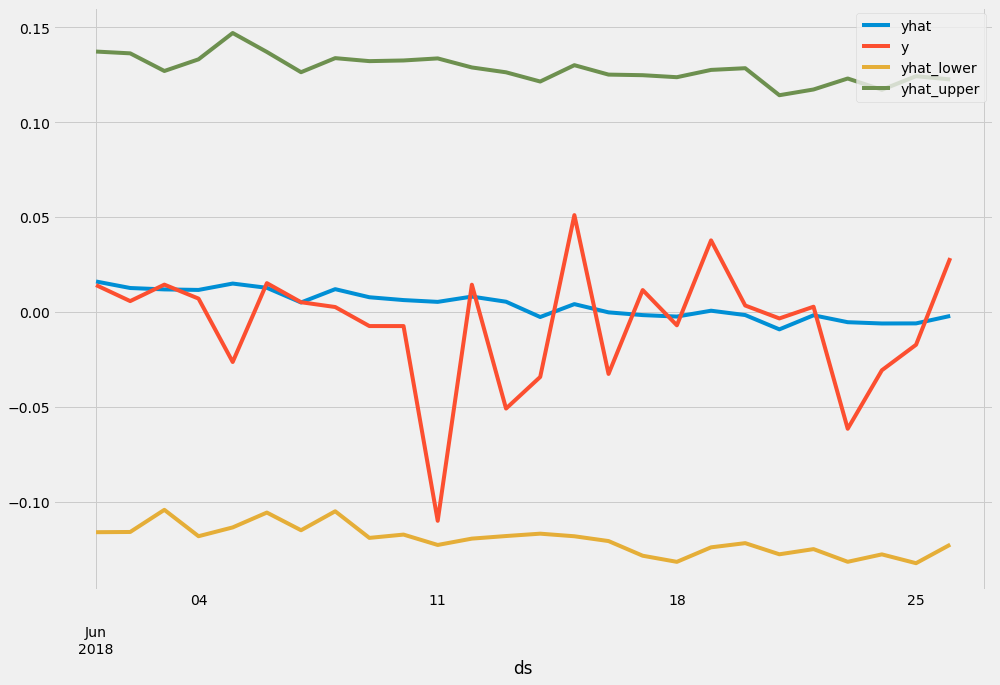

In [796]:
fig, ax=plt.subplots(figsize=(15,10))
forecasted[['yhat','y','yhat_lower','yhat_upper']].plot(ax=ax)

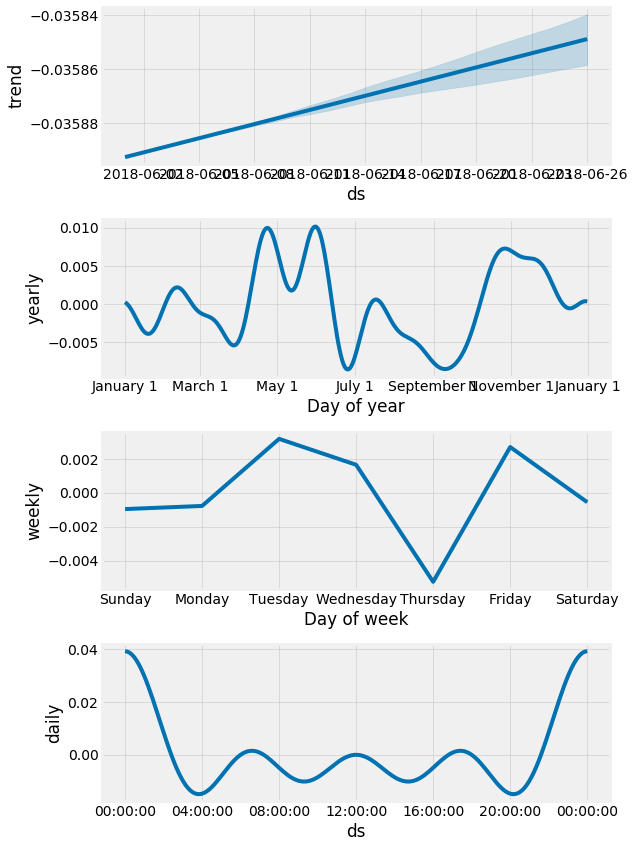

In [797]:
fig=my_model.plot_components(forecast)

In [798]:
forecasted.head()

,y,yhat,yhat_lower,yhat_upper
ds,,,,
2018-06-01,0.014256,0.016152,-0.115940,0.137288
2018-06-02,0.005818,0.012714,-0.115819,0.136345
2018-06-03,0.014493,0.011980,-0.104160,0.127051
2018-06-04,0.007134,0.011702,-0.118053,0.133197
2018-06-05,-0.026266,0.015059,-0.113416,0.147060


#### Inverse the log diff to level??

In [801]:
# from sklearn.metrics import mean_absolute_error  
 
# mean_absolute_error(np.exp(btc_fbpro_df['y']), np.exp(forecast['yhat']))  

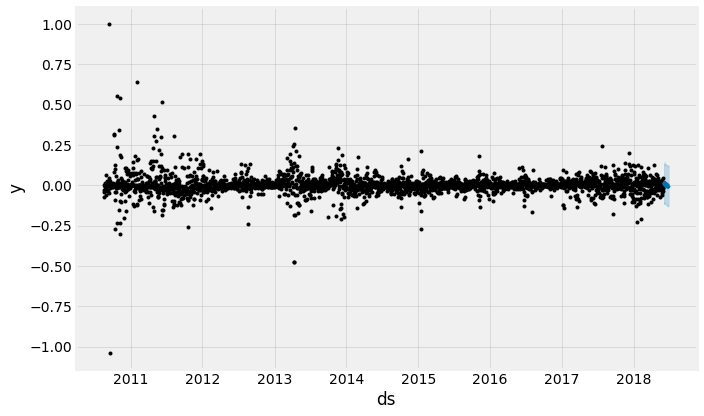

In [802]:
fig=my_model.plot(forecast,
              uncertainty=True)

In [ ]:
# # his is because we took a lag by 1 and first element doesn’t have anything before it to subtract from. The way to convert the differencing to log scale is to add these differences consecutively to the base number. An easy way to do it is to first determine the cumulative sum at index and then add it to the base number. 
# # The cumulative sum can be found as:
# #  Next we’ve to add them to base number. For this lets create a series with all values as base number and add the differences to it. 
# #     This can be done as:

# # predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

# predictions_ARIMA_log = pd.Series(ln_btc_nonzero.ix[0], index=ln_btc_nonzero.index)
# predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
# predictions_ARIMA_log.head()

In [ ]:
# prediction=pd.DataFrame(data)

# prediction['Date']=pd.DatetimeIndex(prediction['ds'])
# # pd.DatetimeIndex(prediction['ds'])
# prediction.set_index('Date', inplace=True)

In [ ]:
# prediction.info()

In [ ]:
# prediction['yhat']

In [ ]:
# prediction['yhat'].plot()
# btc_price_df['log_price'].plot()
# plt.legend(loc='best')
# # plt.show()

# Future Selection for ARIMAX Modeling 

In [803]:
btc_df=pd.read_csv('final_btc.csv')

In [804]:
btc_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3461 entries, 0 to 3460
Data columns (total 32 columns):
Date                 3461 non-null object
USD/CNY Close        3461 non-null float64
EUR/USD Close        3461 non-null float64
USD/JPY Close        3461 non-null float64
BCHAIN/TOTBC         3461 non-null float64
BCHAIN/MKTCP         3461 non-null float64
BCHAIN/TRFEE         3461 non-null float64
BCHAIN/TRFUS         3461 non-null float64
BCHAIN/NTRAN         3461 non-null float64
BCHAIN/NTRAT         3461 non-null float64
BCHAIN/NTREP         3461 non-null float64
BCHAIN/NADDU         3461 non-null float64
BCHAIN/NTRBL         3461 non-null float64
BCHAIN/TOUTV         3461 non-null float64
BCHAIN/ETRAV         3461 non-null float64
BCHAIN/ETRVU         3461 non-null float64
BCHAIN/TRVOU         3461 non-null float64
BCHAIN/MKPRU         3461 non-null float64
BCHAIN/CPTRV         3461 non-null float64
BCHAIN/CPTRA         3461 non-null float64
BCHAIN/HRATE         3461 non-null

In [805]:
btc_df=btc_df[btc_df["BCHAIN/MKPRU"]>0]

In [806]:
btc_df['Date']=pd.DatetimeIndex(btc_df['Date'])

In [807]:
btc_df.set_index('Date', inplace=True)

In [808]:
# Train the Scaler with training data and smooth data

In [809]:
btc_x=btc_df.drop('BCHAIN/MKPRU', axis=1)

# Linear regression to detect Multicolinearity 

Let us normalize the endogeneous variables. 

In [810]:
btc_x=btc_df.drop('BCHAIN/MKPRU', axis=1)

In [811]:
btc_x.columns

Index(['USD/CNY Close', 'EUR/USD Close', 'USD/JPY Close', 'BCHAIN/TOTBC',
       'BCHAIN/MKTCP', 'BCHAIN/TRFEE', 'BCHAIN/TRFUS', 'BCHAIN/NTRAN',
       'BCHAIN/NTRAT', 'BCHAIN/NTREP', 'BCHAIN/NADDU', 'BCHAIN/NTRBL',
       'BCHAIN/TOUTV', 'BCHAIN/ETRAV', 'BCHAIN/ETRVU', 'BCHAIN/TRVOU',
       'BCHAIN/CPTRV', 'BCHAIN/CPTRA', 'BCHAIN/HRATE', 'BCHAIN/MIREV',
       'BCHAIN/ATRCT', 'BCHAIN/BLCHS', 'BCHAIN/AVBLS', 'BCHAIN/MWTRV',
       'BCHAIN/MWNUS', 'BCHAIN/MWNTD', 'BCHAIN/DIFF', 'gold_price',
       'sp_closing_price', 'vix_closing_price'],
      dtype='object')

In [812]:
cols_to_norm=['USD/CNY Close', 'EUR/USD Close', 'USD/JPY Close', 'BCHAIN/TOTBC',
       'BCHAIN/MKTCP', 'BCHAIN/TRFEE', 'BCHAIN/TRFUS', 'BCHAIN/NTRAN',
       'BCHAIN/NTRAT', 'BCHAIN/NTREP', 'BCHAIN/NADDU', 'BCHAIN/NTRBL',
       'BCHAIN/TOUTV', 'BCHAIN/ETRAV', 'BCHAIN/ETRVU', 'BCHAIN/TRVOU',
       'BCHAIN/CPTRV', 'BCHAIN/CPTRA', 'BCHAIN/HRATE', 'BCHAIN/MIREV',
       'BCHAIN/ATRCT', 'BCHAIN/BLCHS', 'BCHAIN/AVBLS', 'BCHAIN/MWTRV',
       'BCHAIN/MWNUS', 'BCHAIN/MWNTD', 'BCHAIN/DIFF', 'gold_price',
       'sp_closing_price', 'vix_closing_price']

In [813]:
btc_x[cols_to_norm] = btc_x[cols_to_norm].apply(lambda x:(x-x.min())/(x.max()-x.min()))

In [814]:
btc_x.head()

,USD/CNY Close,EUR/USD Close,USD/JPY Close,BCHAIN/TOTBC,BCHAIN/MKTCP,BCHAIN/TRFEE,BCHAIN/TRFUS,BCHAIN/NTRAN,BCHAIN/NTRAT,BCHAIN/NTREP,...,BCHAIN/ATRCT,BCHAIN/BLCHS,BCHAIN/AVBLS,BCHAIN/MWTRV,BCHAIN/MWNUS,BCHAIN/MWNTD,BCHAIN/DIFF,gold_price,sp_closing_price,vix_closing_price
Date,,,,,,,,,,,,,,,,,,,,,
2010-08-17,0.822007,0.561088,0.195324,0.000000,1.489878e-07,0.000448,2.267255e-09,0.000171,0.000000,0.000179,...,0.0,0.0,0.000451,0.0,0.0,0.0,0.0,0.207649,0.024824,0.390890
2010-08-18,0.817549,0.556586,0.194523,0.000497,1.172407e-07,0.001043,5.079904e-09,0.000222,0.000001,0.000232,...,0.0,0.0,0.001322,0.0,0.0,0.0,0.0,0.203807,0.025711,0.397581
2010-08-19,0.815483,0.547358,0.192319,0.001021,5.898157e-08,0.000000,0.000000e+00,0.000204,0.000002,0.000213,...,0.0,0.0,0.000241,0.0,0.0,0.0,0.0,0.209717,0.015562,0.445188
2010-08-20,0.816353,0.522373,0.199531,0.001645,3.651885e-08,0.000000,0.000000e+00,0.000265,0.000004,0.000276,...,0.0,0.0,0.000184,0.0,0.0,0.0,0.0,0.212673,0.013403,0.420741
2010-08-21,0.816353,0.522373,0.199531,0.002333,4.069909e-08,0.000000,0.000000e+00,0.000163,0.000005,0.000170,...,0.0,0.0,0.000081,0.0,0.0,0.0,0.0,0.212673,0.013403,0.420741


In [815]:
X = btc_x.values
y = btc_df['BCHAIN/MKPRU'].values

In [816]:
#Splitting the data into training and test sets

# x_train,x_test,y_train,y_test = train_test_split(X,y,test_size = 0.3,random_state = 100)

In [817]:
print (X.shape,y.shape)


(2871, 30) (2871,)


In [818]:
import statsmodels.api as sma
X = sma.add_constant(X) ## let's add an intercept (beta_0) to our model

In [819]:
import statsmodels.formula.api as sm
lm = sm.OLS(y,X).fit()
lm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 1.695e+06
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        07:29:46   Log-Likelihood:                -12854.
No. Observations:                2871   AIC:                         2.577e+04
Df Residuals:                    2840   BIC:                         2.596e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         25.1113      8.895      2.823      0.005       7.669      42.553
x1           -56.2298      6.563     -8.568      0.000     -69.099     -43.361
x2            32.1267      5.093      6.308      0.000      22.140      42.114
x3           -13.1798      6.982     -1.888      0.059     -26.870       0.510
x4           -94.2478     14.820     -6.360      0.000    -123.307     -65.189
x5          1.853e+04     46.167    401.421      0.000    1.84e+04    1.86e+04
x6           -36.6970     18.125     -2.025      0.043     -72.237      -1.157
x7          -462.5183     34.890    -13.256      0.000    -530.931    -394.106
x8           -72.5278     24.933     -2.909      0.004    -121.416     -23.640
x9          2246.1848    144.811     15.511      0.000    1962.239    2530.130
x10           33.7040     20.737      1.625      0.104      -6.957      74.365
x11          152.9913     21.607      7.081      0.000     110.625     195.357
x12           36.6911     10.737      3.417      0.001      15.638      57.744
x13            7.1403      9.326      0.766      0.444     -11.146      25.427
x14            3.4313      9.561      0.359      0.720     -15.317      22.179
x15           82.2758     17.801      4.622      0.000      47.372     117.179
x16           24.5346     14.994      1.636      0.102      -4.865      53.934
x17           15.6765      8.909      1.760      0.079      -1.791      33.144
x18          346.6076     11.419     30.352      0.000     324.216     368.999
x19         -809.0097     41.443    -19.521      0.000    -890.271    -727.749
x20          872.9663     64.498     13.535      0.000     746.499     999.434
x21           54.4923      7.804      6.983      0.000      39.190      69.794
x22        -1595.6774    134.840    -11.834      0.000   -1860.072   -1331.283
x23           -1.2793      7.878     -0.162      0.871     -16.727      14.168
x24          -10.4309     13.641     -0.765      0.445     -37.177      16.316
x25         -623.4672     77.041     -8.093      0.000    -774.529    -472.406
x26           23.1288      3.819      6.056      0.000      15.640      30.618
x27          546.1784     39.116     13.963      0.000     469.481     622.876
x28          -16.6419      5.742     -2.898      0.004     -27.900      -5.384
x29          -68.7542     19.329     -3.557      0.000    -106.654     -30.854
x30          -13.7725      5.464     -2.520      0.012     -24.487      -3.058
==============================================================================
Omnibus:                     3406.562   Durbin-Watson:                   0.553
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1943153.045
Skew:                          -5.555   Prob(JB):                         0.00
Kurtosis:                     129.966   Cond. No.                         885.
==

In [820]:
# vif=[variance_inflation_factor(X_train, j) for j in range(X_train.shape[1])]
# vif = pd.concat([pd.DataFrame(btc_df.columns),pd.DataFrame(np.transpose(vif_c))], axis = 1)
# vif

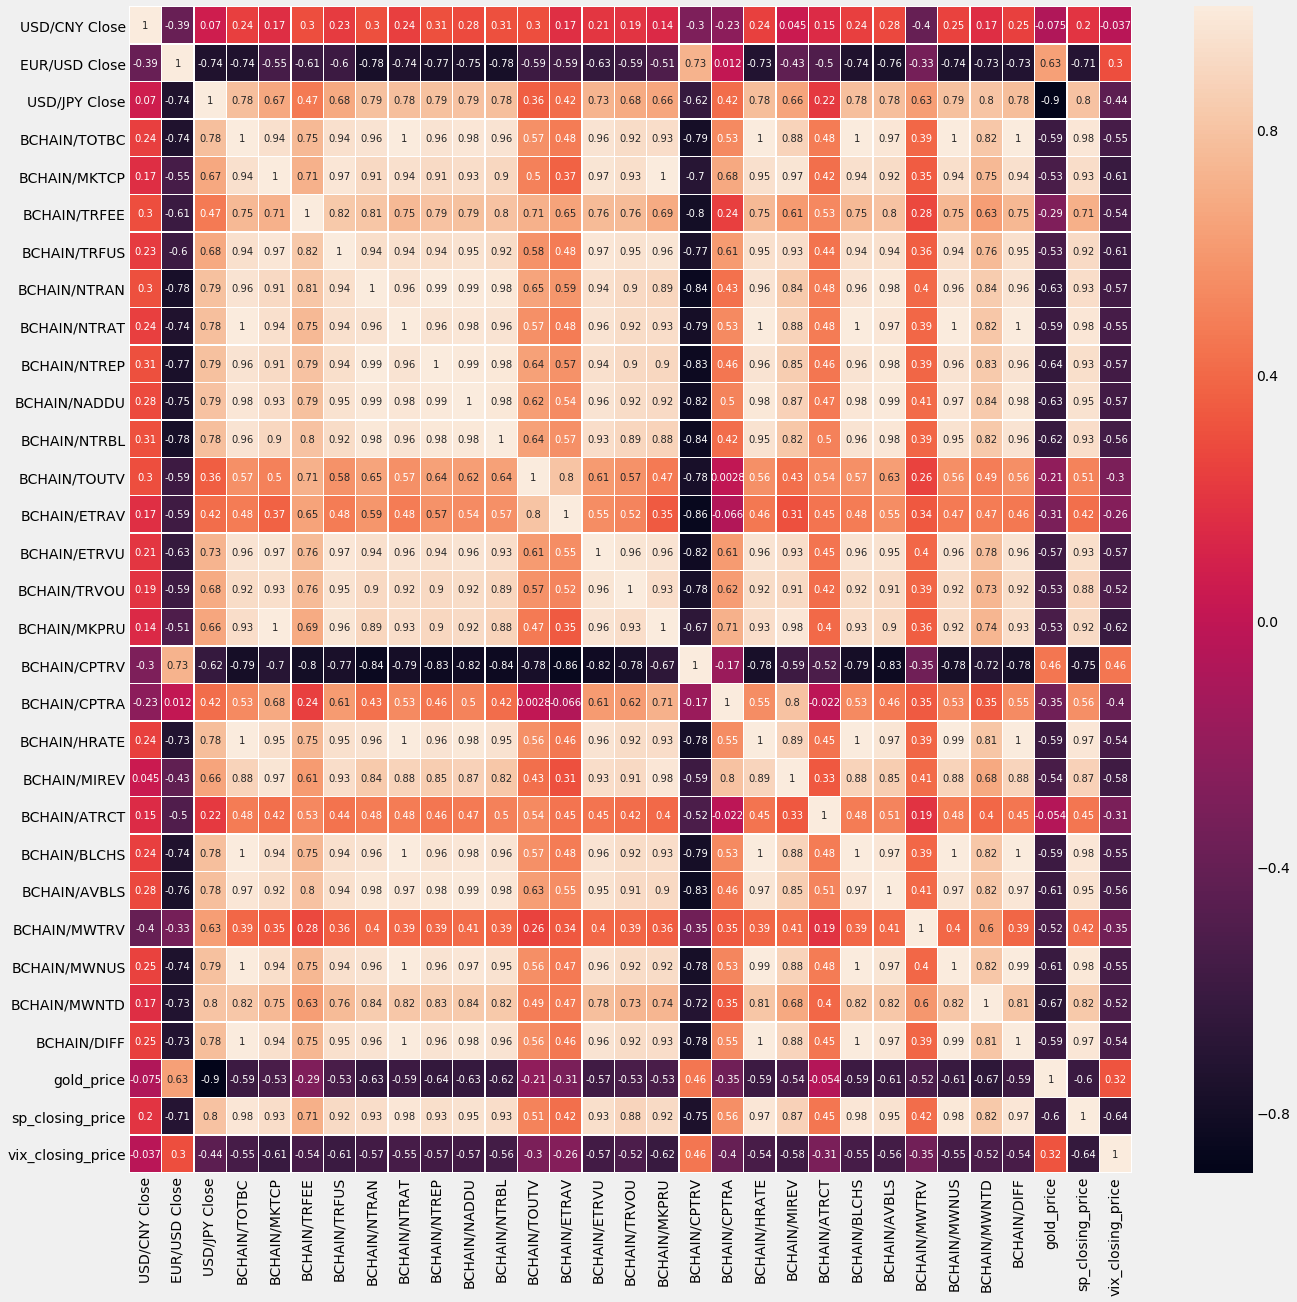

In [821]:
# Get correlation matrix of the meat DataFrame
btc_df_corr = btc_df.corr(method='spearman')

# Customize the heatmap of the corr_meat correlation matrix
fig, ax=plt.subplots(figsize=(20,20))
sns.heatmap(btc_df_corr,
            annot=True,
            linewidths=0.4,
            annot_kws={"size": 10},
           ax=ax)

plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

In [822]:
btc_vif=btc_x.drop(['BCHAIN/TOTBC',
       'BCHAIN/MKTCP', 'BCHAIN/NTRAN',
       'BCHAIN/NTRAT', 'BCHAIN/NTREP', 'BCHAIN/NADDU',  'BCHAIN/HRATE',
       'BCHAIN/MIREV',  'BCHAIN/BLCHS',  'BCHAIN/MWNUS'], axis=1)

In [823]:
X2 = btc_vif.values
y = btc_df['BCHAIN/MKPRU'].values

In [824]:
X2 = sma.add_constant(X2) ## let's add an intercept (beta_0) to our model

In [825]:
lm2 = sm.OLS(y,X2).fit()
lm2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     6279.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        07:29:48   Log-Likelihood:                -21445.
No. Observations:                2871   AIC:                         4.293e+04
Df Residuals:                    2850   BIC:                         4.306e+04
Df Model:                          20                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -379.1161    137.240     -2.762      0.006    -648.216    -110.017
x1            16.1548     82.879      0.195      0.845    -146.354     178.663
x2          -441.4559     90.791     -4.862      0.000    -619.478    -263.434
x3           -92.5708    134.416     -0.689      0.491    -356.134     170.992
x4         -2969.8105    278.600    -10.660      0.000   -3516.089   -2423.532
x5          7424.7521    391.703     18.955      0.000    6656.702    8192.802
x6          -533.0889    154.253     -3.456      0.001    -835.548    -230.630
x7          -543.7304    180.288     -3.016      0.003    -897.238    -190.223
x8          -630.1495    188.444     -3.344      0.001    -999.650    -260.650
x9          1.178e+04    238.648     49.361      0.000    1.13e+04    1.22e+04
x10          -57.1065    287.903     -0.198      0.843    -621.625     507.412
x11          791.7718    167.622      4.724      0.000     463.098    1120.445
x12         4808.7849    152.030     31.630      0.000    4510.685    5106.885
x13          -38.0435    135.964     -0.280      0.780    -304.640     228.553
x14         1177.2039    134.744      8.737      0.000     912.999    1441.409
x15          185.7576    269.138      0.690      0.490    -341.968     713.483
x16          190.8156     71.101      2.684      0.007      51.401     330.231
x17         4679.4471    106.453     43.958      0.000    4470.715    4888.179
x18          877.4854    101.490      8.646      0.000     678.485    1076.486
x19         -240.4671    207.150     -1.161      0.246    -646.647     165.712
x20          -95.2194     87.395     -1.090      0.276    -266.583      76.144
==============================================================================
Omnibus:                      682.178   Durbin-Watson:                   0.725
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29887.726
Skew:                           0.284   Prob(JB):                         0.00
Kurtosis:                      18.796   Cond. No.                         90.4
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [826]:
len(btc_x.columns)

30

In [827]:
vif2=[variance_inflation_factor(X2, j) for j in range(X2.shape[1])]
vif2 = pd.concat([pd.DataFrame(btc_vif.columns),pd.DataFrame(np.transpose(vif2))], axis = 1)
vif2

,0,0
0,USD/CNY Close,298.043349
1,EUR/USD Close,7.004087
2,USD/JPY Close,8.704554
3,BCHAIN/TRFEE,25.834612
4,BCHAIN/TRFUS,7.595595
5,BCHAIN/NTRBL,9.029181
6,BCHAIN/TOUTV,23.724227
7,BCHAIN/ETRAV,1.245823
8,BCHAIN/ETRVU,1.177191
9,BCHAIN/TRVOU,10.453309


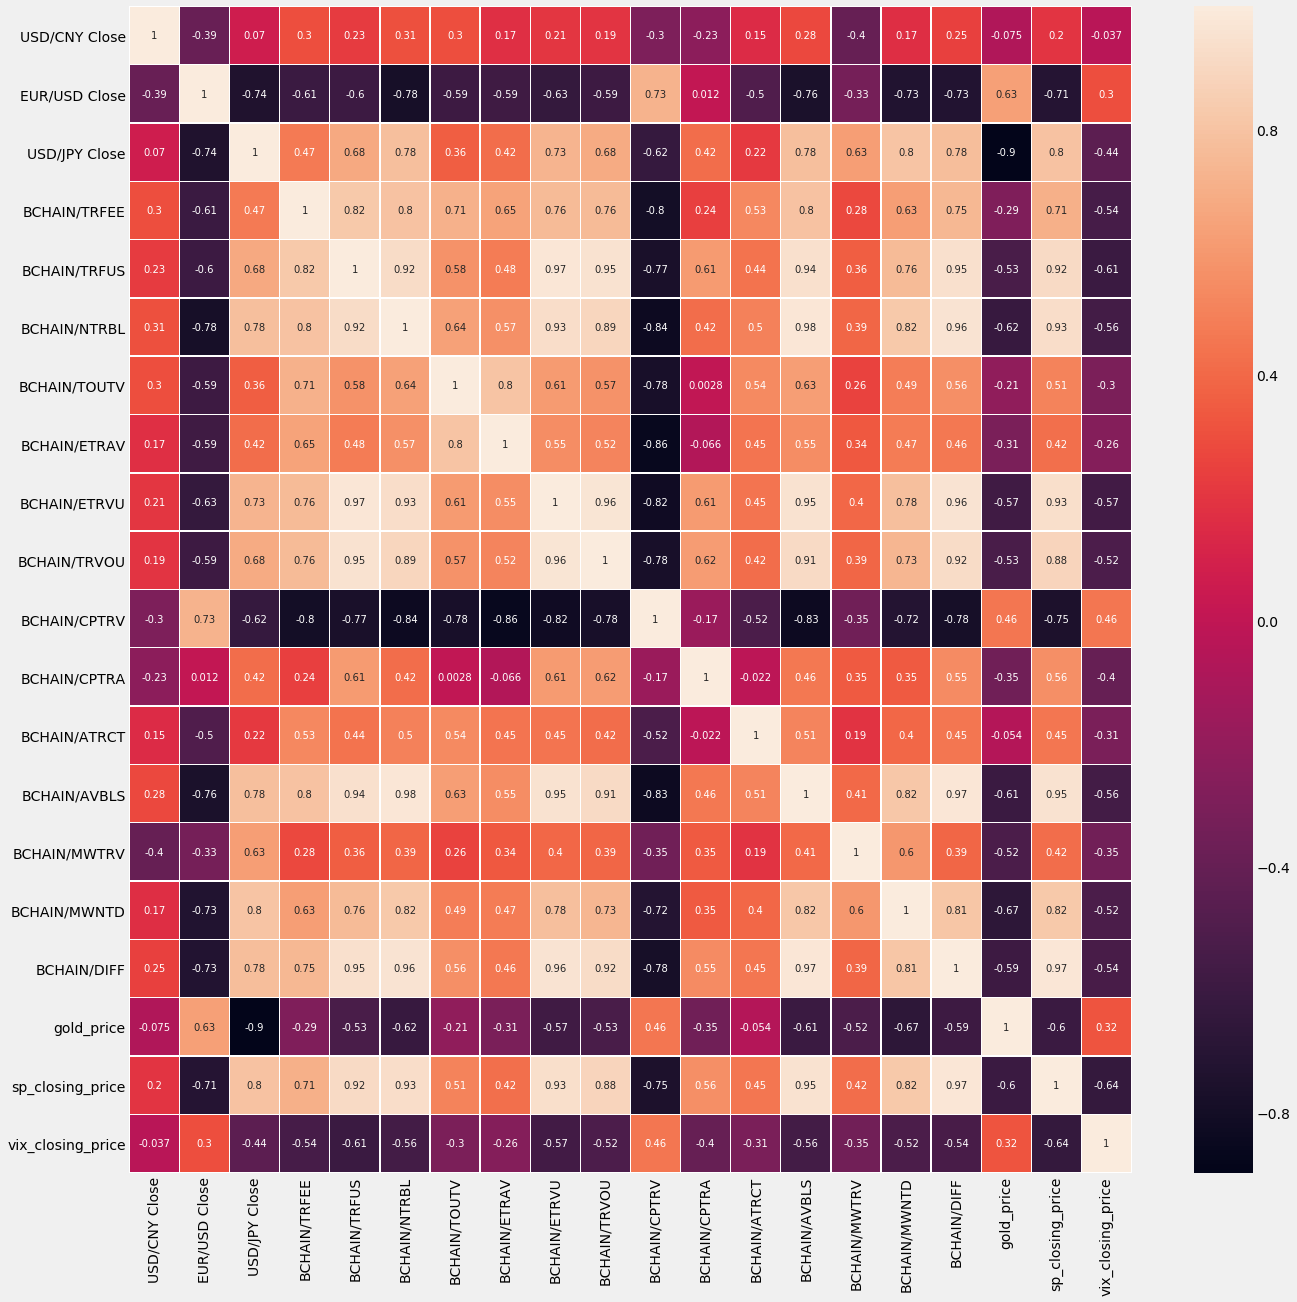

In [828]:
# Get correlation matrix of  DataFrame
btc_vif_corr = btc_vif.corr(method='spearman')


# Customize the heatmap of the corr_meat correlation matrix
fig, ax=plt.subplots(figsize=(20,20))
sns.heatmap(btc_vif_corr,
            annot=True,
            linewidths=0.4,
            annot_kws={"size": 10},
           ax=ax)

plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

In [829]:
btc_vif_II=btc_vif.drop(['sp_closing_price','BCHAIN/AVBLS','BCHAIN/NTRBL','USD/JPY Close'], axis=1)

In [830]:
X3 = btc_vif_II.values
y = btc_df['BCHAIN/MKPRU'].values

In [831]:
X3 = sma.add_constant(X3) ## let's add an intercept (beta_0) to our model

In [832]:
lm3 = sm.OLS(y,X3).fit()
lm3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     7606.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        07:29:49   Log-Likelihood:                -21491.
No. Observations:                2871   AIC:                         4.302e+04
Df Residuals:                    2854   BIC:                         4.312e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -318.9284     57.082     -5.587      0.000    -430.855    -207.002
x1           289.4623     52.666      5.496      0.000     186.195     392.729
x2          -717.3893     72.187     -9.938      0.000    -858.933    -575.846
x3         -2403.7730    257.789     -9.325      0.000   -2909.245   -1898.301
x4          6300.3742    354.744     17.760      0.000    5604.793    6995.955
x5          -434.5227    180.512     -2.407      0.016    -788.470     -80.576
x6          -602.3699    190.911     -3.155      0.002    -976.708    -228.032
x7          1.217e+04    233.874     52.045      0.000    1.17e+04    1.26e+04
x8           135.4223    290.969      0.465      0.642    -435.108     705.952
x9           426.0882    152.652      2.791      0.005     126.770     725.407
x10         5117.2653    130.320     39.267      0.000    4861.735    5372.796
x11           34.1371    130.993      0.261      0.794    -222.713     290.987
x12          115.0511    270.819      0.425      0.671    -415.970     646.072
x13          180.5042     66.275      2.724      0.006      50.552     310.456
x14         4695.9820     93.761     50.084      0.000    4512.135    4879.829
x15          853.3439     67.420     12.657      0.000     721.147     985.541
x16          -15.8265     73.117     -0.216      0.829    -159.194     127.541
==============================================================================
Omnibus:                      689.467   Durbin-Watson:                   0.739
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            29965.879
Skew:                           0.310   Prob(JB):                         0.00
Kurtosis:                      18.815   Cond. No.                         66.3
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [833]:
vif3=[variance_inflation_factor(X3, j) for j in range(X3.shape[1])]
vif3 = pd.concat([pd.DataFrame(btc_vif_II.columns),pd.DataFrame(np.transpose(vif3))], axis = 1)
vif3

,0,0
0,USD/CNY Close,50.002399
1,EUR/USD Close,2.742818
2,BCHAIN/TRFEE,5.336443
3,BCHAIN/TRFUS,6.306702
4,BCHAIN/TOUTV,7.181882
5,BCHAIN/ETRAV,1.211183
6,BCHAIN/ETRVU,1.171712
7,BCHAIN/TRVOU,9.735866
8,BCHAIN/CPTRV,5.222854
9,BCHAIN/CPTRA,1.936054


In [834]:
btc_vif_III=btc_vif_II.drop(['USD/CNY Close','BCHAIN/TRVOU'], axis=1)

In [835]:
X4 = btc_vif_III.values
y = btc_df['BCHAIN/MKPRU'].values

In [836]:
X4 = sma.add_constant(X4) ## let's add an intercept (beta_0) to our model

In [837]:
lm4 = sm.OLS(y,X4).fit()
lm4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     8605.
Date:                Fri, 20 Jul 2018   Prob (F-statistic):               0.00
Time:                        07:29:49   Log-Likelihood:                -21506.
No. Observations:                2871   AIC:                         4.304e+04
Df Residuals:                    2856   BIC:                         4.313e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -200.5660     53.014     -3.783      0.000    -304.517     -96.615
x1          -805.0206     70.731    -11.381      0.000    -943.710    -666.331
x2         -1707.5021    224.435     -7.608      0.000   -2147.572   -1267.432
x3          5755.4650    337.782     17.039      0.000    5093.143    6417.787
x4          -363.5697    180.935     -2.009      0.045    -718.347      -8.792
x5          -599.0167    191.788     -3.123      0.002    -975.075    -222.959
x6          1.237e+04    195.091     63.396      0.000     1.2e+04    1.28e+04
x7           785.6221    138.601      5.668      0.000     513.854    1057.390
x8          4934.6381    126.575     38.986      0.000    4686.450    5182.826
x9          -140.3692    127.489     -1.101      0.271    -390.350     109.611
x10         -137.3522    268.158     -0.512      0.609    -663.156     388.452
x11          255.0663     65.122      3.917      0.000     127.376     382.757
x12         4798.1295     91.518     52.428      0.000    4618.682    4977.577
x13          904.9468     67.062     13.494      0.000     773.452    1036.442
x14           -0.1616     72.744     -0.002      0.998    -142.797     142.474
==============================================================================
Omnibus:                      717.938   Durbin-Watson:                   0.755
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            31242.472
Skew:                           0.385   Prob(JB):                         0.00
Kurtosis:                      19.142   Cond. No.                         58.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [838]:
vif4=[variance_inflation_factor(X4, j) for j in range(X4.shape[1])]
vif4 = pd.concat([pd.DataFrame(btc_vif_III.columns),pd.DataFrame(np.transpose(vif4))], axis = 1)
vif4

,0,0
0,EUR/USD Close,42.708415
1,BCHAIN/TRFEE,5.073313
2,BCHAIN/TRFUS,4.733516
3,BCHAIN/TOUTV,6.447819
4,BCHAIN/ETRAV,1.204971
5,BCHAIN/ETRVU,1.170936
6,BCHAIN/CPTRV,6.708381
7,BCHAIN/CPTRA,1.580446
8,BCHAIN/ATRCT,6.276515
9,BCHAIN/MWTRV,2.346304


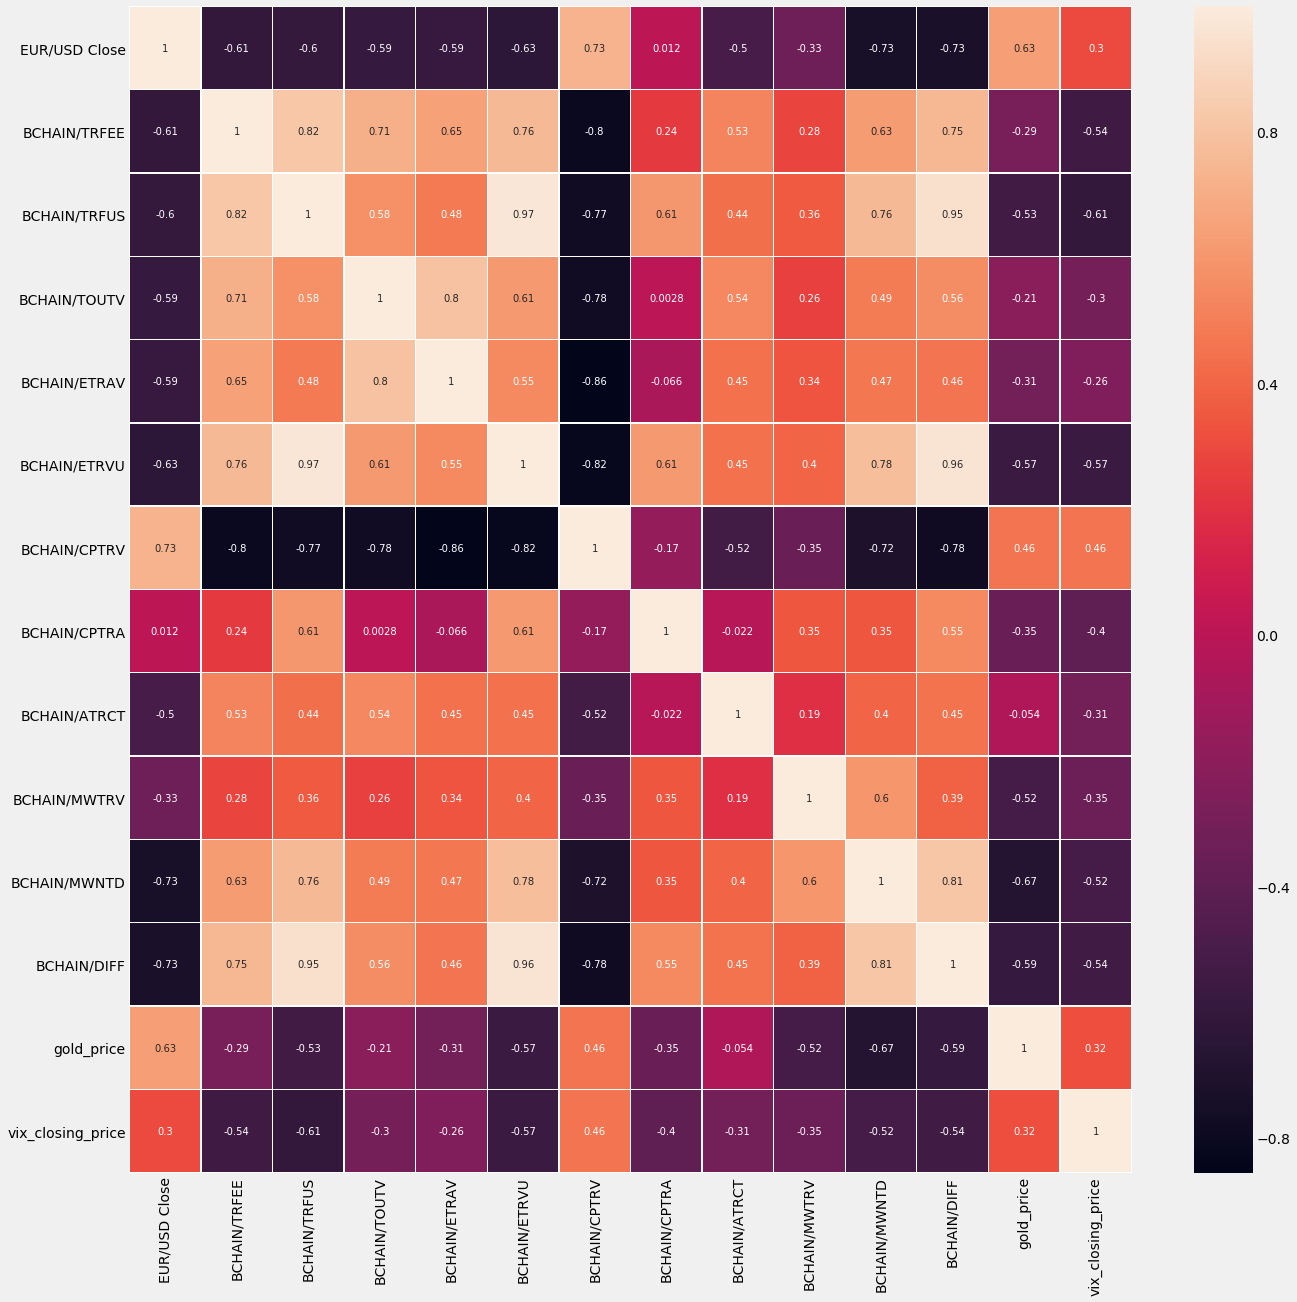

In [839]:
# Get correlation matrix of  DataFrame
btc_vif_III_corr = btc_vif_III.corr(method='spearman')


# Customize the heatmap of the corr_meat correlation matrix
fig, ax=plt.subplots(figsize=(20,20))
sns.heatmap(btc_vif_III_corr,
            annot=True,
            linewidths=0.4,
            annot_kws={"size": 10},
           ax=ax)

plt.xticks(rotation=90)
plt.yticks(rotation=0) 
plt.show()

In [840]:
# Define the final Data Frame both exogeneous and Endogenous 

In [841]:
btc_vif_III.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2871 entries, 2010-08-17 to 2018-06-26
Freq: D
Data columns (total 14 columns):
EUR/USD Close        2871 non-null float64
BCHAIN/TRFEE         2871 non-null float64
BCHAIN/TRFUS         2871 non-null float64
BCHAIN/TOUTV         2871 non-null float64
BCHAIN/ETRAV         2871 non-null float64
BCHAIN/ETRVU         2871 non-null float64
BCHAIN/CPTRV         2871 non-null float64
BCHAIN/CPTRA         2871 non-null float64
BCHAIN/ATRCT         2871 non-null float64
BCHAIN/MWTRV         2871 non-null float64
BCHAIN/MWNTD         2871 non-null float64
BCHAIN/DIFF          2871 non-null float64
gold_price           2871 non-null float64
vix_closing_price    2871 non-null float64
dtypes: float64(14)
memory usage: 336.4 KB


In [842]:
btc_vif_III.columns

Index(['EUR/USD Close', 'BCHAIN/TRFEE', 'BCHAIN/TRFUS', 'BCHAIN/TOUTV',
       'BCHAIN/ETRAV', 'BCHAIN/ETRVU', 'BCHAIN/CPTRV', 'BCHAIN/CPTRA',
       'BCHAIN/ATRCT', 'BCHAIN/MWTRV', 'BCHAIN/MWNTD', 'BCHAIN/DIFF',
       'gold_price', 'vix_closing_price'],
      dtype='object')

In [843]:
columns=['EUR/USD Close', 'BCHAIN/TRFEE', 'BCHAIN/TRFUS', 'BCHAIN/TOUTV',
       'BCHAIN/ETRAV', 'BCHAIN/ETRVU', 'BCHAIN/CPTRV', 'BCHAIN/CPTRA',
       'BCHAIN/ATRCT', 'BCHAIN/MWTRV', 'BCHAIN/MWNTD', 'BCHAIN/DIFF',
       'gold_price', 'vix_closing_price', 'BCHAIN/MKPRU']

In [844]:
btc_final_df=btc_df[columns]

In [845]:
btc_final_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2871 entries, 2010-08-17 to 2018-06-26
Freq: D
Data columns (total 15 columns):
EUR/USD Close        2871 non-null float64
BCHAIN/TRFEE         2871 non-null float64
BCHAIN/TRFUS         2871 non-null float64
BCHAIN/TOUTV         2871 non-null float64
BCHAIN/ETRAV         2871 non-null float64
BCHAIN/ETRVU         2871 non-null float64
BCHAIN/CPTRV         2871 non-null float64
BCHAIN/CPTRA         2871 non-null float64
BCHAIN/ATRCT         2871 non-null float64
BCHAIN/MWTRV         2871 non-null float64
BCHAIN/MWNTD         2871 non-null float64
BCHAIN/DIFF          2871 non-null float64
gold_price           2871 non-null float64
vix_closing_price    2871 non-null float64
BCHAIN/MKPRU         2871 non-null float64
dtypes: float64(15)
memory usage: 358.9 KB


In [846]:
btc_final_df.describe().T

,count,mean,std,min,25%,50%,75%,max
EUR/USD Close,2871.0,1.243136e+00,1.147900e-01,1.038720,1.126145e+00,1.261300e+00,1.339400e+00,1.483000e+00
BCHAIN/TRFEE,2871.0,6.346880e+01,1.176608e+02,0.000000,1.201890e+01,2.463261e+01,5.260579e+01,1.495946e+03
BCHAIN/TRFUS,2871.0,2.934748e+05,1.386066e+06,0.000000,2.397240e+02,5.466663e+03,3.592248e+04,2.272484e+07
BCHAIN/TOUTV,2871.0,1.644836e+06,2.263060e+06,17622.840000,6.290582e+05,1.201448e+06,2.044596e+06,4.599222e+07
BCHAIN/ETRAV,2871.0,2.118801e+05,2.663756e+05,6221.000000,1.099450e+05,1.816510e+05,2.599272e+05,5.825066e+06
BCHAIN/ETRVU,2871.0,2.600935e+08,6.204764e+08,527.000000,2.193508e+06,4.856788e+07,1.674950e+08,5.760245e+09
BCHAIN/CPTRV,2871.0,5.403438e+00,1.052696e+01,0.136531,1.157135e+00,2.155312e+00,4.589164e+00,1.431794e+02
BCHAIN/CPTRA,2871.0,1.921961e+01,2.594389e+01,0.134860,5.210750e+00,8.489658e+00,2.099751e+01,1.616861e+02
BCHAIN/ATRCT,2871.0,8.107373e+00,4.653220e+00,0.000000,6.750000e+00,8.150000e+00,1.064167e+01,4.773333e+01
BCHAIN/MWTRV,2871.0,1.156597e+05,2.730035e+05,0.000000,0.000000e+00,6.343452e+04,1.609716e+05,8.484600e+06


In [847]:
btc_log=btc_final_df.apply(np.log)

In [848]:
y=btc_log['BCHAIN/MKPRU']

In [879]:
X=btc_log.drop(['BCHAIN/MKPRU','BCHAIN/ATRCT','BCHAIN/MWTRV','BCHAIN/MWNTD'], axis=1) # The last three variables generate a significant missing valuesa and inf after log transformation and first difference.
# BCHAIN/ATRCT 2399 non-null float64
# BCHAIN/MWTRV 1981 non-null float64
# BCHAIN/MWNTD 2212 non-null float64

In [850]:
# btc_norm_df = btc_final_df[columns].apply(lambda x:(x-x.min())/(x.max()-x.min()))

In [851]:
# btc_norm_df.info()

In [852]:
# X=btc_norm_df.drop(['BCHAIN/MKPRU'], axis=1)

In [853]:
# y=btc_norm_df['BCHAIN/MKPRU']

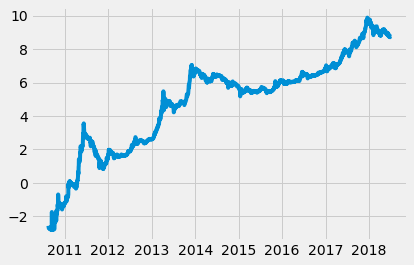

In [854]:
plt.plot(y)

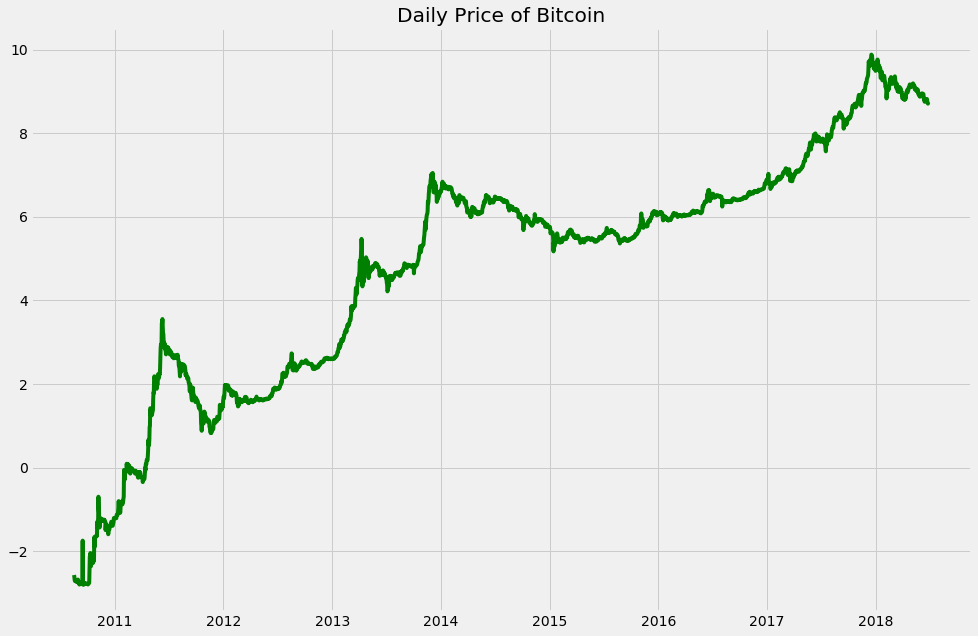

Results of Dickey-Fuller Test:
Test Statistic                   -2.570922
p-value                           0.099157
#Lags Used                       16.000000
Number of Observations Used    2854.000000
Critical Value (1%)              -3.432643
Critical Value (5%)              -2.862553
Critical Value (10%)             -2.567309
dtype: float64
weak evidence against null hypothesis, time series has a unit root, indicating it is non-stationary 


In [855]:
adf_test(y)

In [856]:
y_diff=btc_log['BCHAIN/MKPRU'].diff()

In [857]:
y_diff.describe()

count    2870.000000
mean        0.003937
std         0.063723
min        -1.039266
25%        -0.013708
50%         0.000965
75%         0.018673
max         1.004342
Name: BCHAIN/MKPRU, dtype: float64

In [858]:
y_diff.dropna(inplace=True)

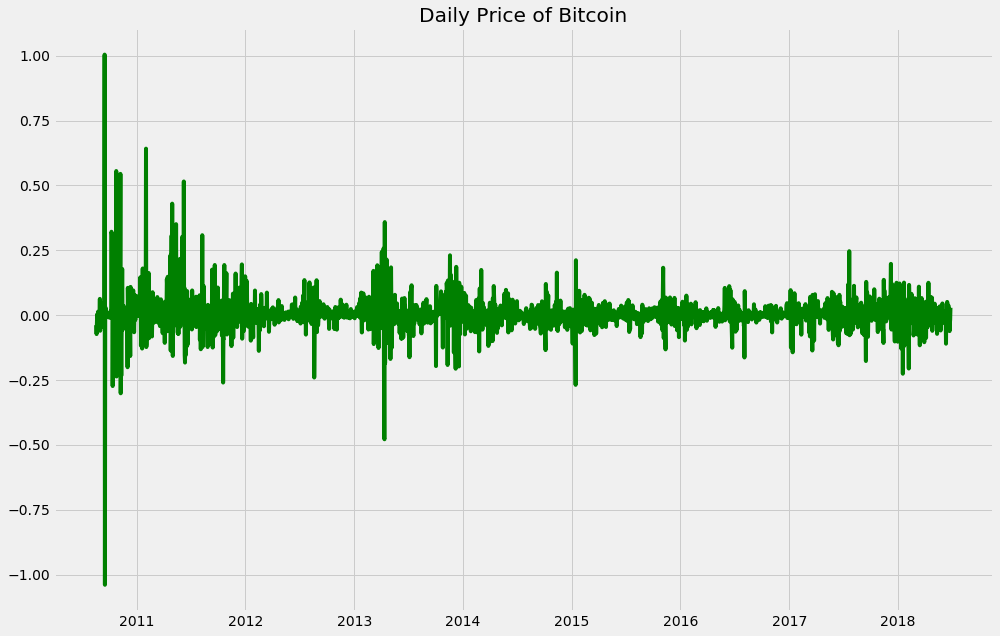

Results of Dickey-Fuller Test:
Test Statistic                -1.087471e+01
p-value                        1.340772e-19
#Lags Used                     1.500000e+01
Number of Observations Used    2.854000e+03
Critical Value (1%)           -3.432643e+00
Critical Value (5%)           -2.862553e+00
Critical Value (10%)          -2.567309e+00
dtype: float64
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [859]:
adf_test(y_diff)

In [860]:
y_acf=acf(y_diff, nlags=40)
y_pacf=pacf(y_diff, nlags=40)

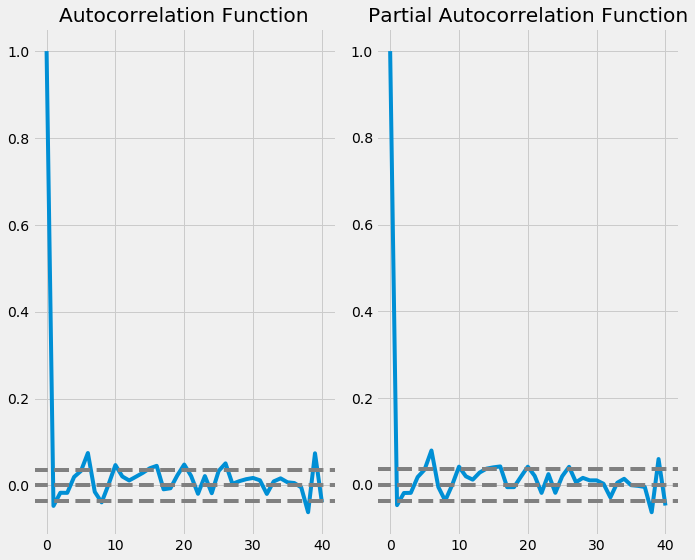

In [861]:
#Plot ACF: 
fig, ax=plt.subplots(figsize=(10,8))
plt.subplot(121) 
plt.plot(y_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_diff)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF: 
plt.subplot(122)
plt.plot(y_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(y_diff)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(y_diff)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

In [880]:
def diff(x):
     return x-x.shift(periods=1)
X_diff=X.apply(diff)
X_diff=add_constant(X_diff)

In [885]:
X_diff=X_diff.replace([np.inf, -np.inf], np.nan)
X_diff.fillna(method='bfill', inplace= True)

In [886]:
# Variables
exog=X_diff
endog=y

In [887]:
#nobs = endog.shape[0]
# Fit the model
mod = SARIMAX(endog, exog, order=(6,0,6))
fit_res = mod.fit(disp=False)
print(fit_res.summary())

c:\users\getud\dropbox\dereje~1\nssds~1\test\venvtest\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1051: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if self.state_error and params_variance == []:
c:\users\getud\dropbox\dereje~1\nssds~1\test\venvtest\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


                           Statespace Model Results                           
Dep. Variable:           BCHAIN/MKPRU   No. Observations:                 2871
Model:               SARIMAX(6, 0, 6)   Log Likelihood                2905.123
Date:                Fri, 20 Jul 2018   AIC                          -5760.245
Time:                        08:04:49   BIC                          -5611.185
Sample:                    08-17-2010   HQIC                         -5706.508
                         - 06-26-2018                                         
Covariance Type:                  opg                                         
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                 4.8025      3.000      1.601      0.109      -1.077      10.682
EUR/USD Close        -5.2484      0.255    -20.599      0.000      -5.748      -4.749
BCHAIN/TRFEE         -0.

In [ ]:
x=[6132.56,5848.26,6203.9,6387.31,6347.86,6613.27,6504.93,6584.77,6531.2,6600.99,6755.56,6704.18,6664.21,6302.49,6381.87,6245.63]
len(x)

In [ ]:
forecast,std,conf=results.forecast(16, alpha=0.01)
# plt.plot(forecast)
fig = plt.figure(figsize=(12,8))
plt.plot(np.exp(forecast))
#plt.plot(x)
print(np.exp(forecast))


In [ ]:
CausalityTestResults(btc_log_diff['EUR/USD Close'], btc_log_diff['BCHAIN/MKPRU'],test='granger')

In [ ]:
btc_log_diff.columns

In [ ]:
# print(sm.tsa.stattools.grangercausalitytests(btc_log_diff[['BCHAIN/MKPRU','EUR/USD Close']].dropna(),3))

In [ ]:
# def granger_casuality(timeseries):
#     print ('Results of Dickey-Fuller Test:')
#     granger = sm.tsa.stattools.grangercausalitytests((btc_log_diff[['EUR/USD Close','BCHAIN/MKPRU' ]].dropna(),1)
# #     granger_output = pd.Series(granger[1:4], index=['lags','sr based F test','ssr based chi2 test','likelihood ratio test'])
# # for key,value in granger[5].items():
# #      granger_output['Critical Value (%s)'%key] = valu
# print(granger)

In [ ]:
btc_log_diff.info()

In [ ]:
X=btc_log_diff[[ 'USD/JPY Close', 'BCHAIN/TRFEE',
       'BCHAIN/TRFUS',  'BCHAIN/TOUTV', 'BCHAIN/ETRAV',
       'BCHAIN/ETRVU', 'BCHAIN/TRVOU',  'BCHAIN/CPTRV',
        'BCHAIN/DIFF']][:'2018-06-20']

In [ ]:
X_test=btc_log_diff[[ 'USD/JPY Close', 'BCHAIN/TRFEE',
       'BCHAIN/TRFUS',  'BCHAIN/TOUTV', 'BCHAIN/ETRAV',
       'BCHAIN/ETRVU', 'BCHAIN/TRVOU',  'BCHAIN/CPTRV',
        'BCHAIN/DIFF']]['2018-06-21':]

In [ ]:
Y=btc_log_diff[[ 'BCHAIN/MKPRU']][:'2018-06-20']

In [ ]:
model3=sm.tsa.ARIMA(endog=Y,exog=X,order=[1,0,2])
results3=model3.fit()
print(results3.summary())

In [ ]:
results3.forecast(steps=1, exog=X_test)

In [ ]:
from pandas import Series
from sklearn.preprocessing import StandardScaler
from math import sqrt
# define contrived series
data = [1.0, 5.5, 9.0, 2.6, 8.8, 3.0, 4.1, 7.9, 6.3]
series = Series(data)
print(series)
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = StandardScaler()
scaler = scaler.fit(values)
print('Mean: %f, StandardDeviation: %f' % (scaler.mean_, sqrt(scaler.var_)))
# normalize the dataset and print
standardized = scaler.transform(values)
print(standardized)
# inverse transform and print
inversed = scaler.inverse_transform(standardized)
print(inversed)

In [ ]:
from pandas import Series
from sklearn.preprocessing import MinMaxScaler
# define contrived series
data = [10.0, 20.0, 30.0, 40.0, 50.0, 60.0, 70.0, 80.0, 90.0, 100.0]
series = Series(data)
print(series)
# prepare data for normalization
values = series.values
values = values.reshape((len(values), 1))
# train the normalization
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(values)
print('Min: %f, Max: %f' % (scaler.data_min_, scaler.data_max_))
# normalize the dataset and print
normalized = scaler.transform(values)
print(normalized)
# inverse transform and print
inversed = scaler.inverse_transform(normalized)
print(inversed)